<a href="https://colab.research.google.com/github/tzs930/deeprl_practice_colab/blob/master/day3/day3_GAIL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# GAIL (Generative Adversarial Imitation Learning) 실습

이번 실습자료는 GAIL 저자 (Jonathan Ho)의  [구현코드](/https://github.com/openai/imitation.git)를 바탕으로 제작되었습니다. 직접적인 구현 자체 (`TrainsitionClassifier`, `ImitationOptimizer`) 위주로 실습자료를 만들었고, 구현에 필요한 유틸리티 메서드들은 저자코드 저장소에서 그대로 받아와서 사용하게 됩니다. 

## 환경설정

In [1]:
!apt-get install -y xvfb python-opengl swig ffmpeg zlib1g-dev python3-tk
!pip install theano==0.8.2 gym==0.1.0 mujoco_py==0.4.0 
!pip install JSAnimation PyOpenGL piglet pyglet xlib pyvirtualdisplay box2d-py mako==1.0.7 
from pyvirtualdisplay import Display
display = Display(visible=0, size=(1400, 900))
display.start()
import os
os.environ["DISPLAY"] = ":" + str(display.display) + "." + str(display.screen)

Reading package lists... Done
Building dependency tree       
Reading state information... Done
zlib1g-dev is already the newest version (1:1.2.11.dfsg-0ubuntu2).
python-opengl is already the newest version (3.1.0+dfsg-1).
swig is already the newest version (3.0.12-1).
python3-tk is already the newest version (3.6.7-1~18.04).
ffmpeg is already the newest version (7:3.4.4-0ubuntu0.18.04.1).
xvfb is already the newest version (2:1.19.6-1ubuntu4.2).
0 upgraded, 0 newly installed, 0 to remove and 13 not upgraded.


In [3]:
!git init .
!git remote add origin https://github.com/tzs930/imitation.git
!git pull origin master

Reinitialized existing Git repository in /content/.git/
fatal: remote origin already exists.
From https://github.com/tzs930/imitation
 * branch            master     -> FETCH_HEAD
Already up to date.


## Generative Adversarial Learning을 통해 Reward를 학습 : `class TrainsitionClassifier`

In [0]:
from policyopt import nn, rl, util, RaggedArray, ContinuousSpace, FiniteSpace, optim, thutil
import numpy as np
from contextlib import contextmanager
import theano; from theano import tensor

class TransitionClassifier(nn.Model):
    '''Reward/adversary for generative-adversarial training'''

    def __init__(self, obsfeat_space, action_space, hidden_spec, max_kl, adam_lr, adam_steps, ent_reg_weight,
                 enable_inputnorm, include_time, time_scale, favor_zero_expert_reward, varscope_name):
        self.obsfeat_space, self.action_space = obsfeat_space, action_space
        self.hidden_spec = hidden_spec
        self.max_kl = max_kl
        self.adam_steps = adam_steps
        self.ent_reg_weight = ent_reg_weight; assert ent_reg_weight >= 0
        self.include_time = include_time
        self.time_scale = time_scale
        self.favor_zero_expert_reward = favor_zero_expert_reward

        with nn.variable_scope(varscope_name) as self.__varscope:
            # Map (s,a) pairs to classifier scores (log probabilities of classes)
            obsfeat_B_Df = tensor.matrix(name='obsfeat_B_Df')
            a_B_Da = tensor.matrix(name='a_B_Da', dtype=theano.config.floatX if self.action_space.storage_type == float else 'int64')
            t_B = tensor.vector(name='t_B')

            scaled_t_B = self.time_scale * t_B

            if isinstance(self.action_space, ContinuousSpace):
                # For a continuous action space, map observation-action pairs to a real number (reward)
                trans_B_Doa = tensor.concatenate([obsfeat_B_Df, a_B_Da], axis=1)
                trans_dim = self.obsfeat_space.dim + self.action_space.dim
                # Normalize
                with nn.variable_scope('inputnorm'):
                    self.inputnorm = (nn.Standardizer if enable_inputnorm else nn.NoOpStandardizer)(self.obsfeat_space.dim + self.action_space.dim)
                normedtrans_B_Doa = self.inputnorm.standardize_expr(trans_B_Doa)
                if self.include_time:
                    net_input = tensor.concatenate([normedtrans_B_Doa, scaled_t_B[:,None]], axis=1)
                    net_input_dim = trans_dim + 1
                else:
                    net_input = normedtrans_B_Doa
                    net_input_dim = trans_dim
                # Compute scores
                with nn.variable_scope('hidden'):
                    net = nn.FeedforwardNet(net_input, (net_input_dim,), self.hidden_spec)
                with nn.variable_scope('out'):
                    out_layer = nn.AffineLayer(net.output, net.output_shape, (1,), initializer=np.zeros((net.output_shape[0], 1)))
                scores_B = out_layer.output[:,0]

            else:
                # For a finite action space, map observation observations to a vector of rewards

                # Normalize observations
                with nn.variable_scope('inputnorm'):
                    self.inputnorm = (nn.Standardizer if enable_inputnorm else nn.NoOpStandardizer)(self.obsfeat_space.dim)
                normedobs_B_Df = self.inputnorm.standardize_expr(obsfeat_B_Df)
                if self.include_time:
                    net_input = tensor.concatenate([normedobs_B_Df, scaled_t_B[:,None]], axis=1)
                    net_input_dim = self.obsfeat_space.dim + 1
                else:
                    net_input = normedobs_B_Df
                    net_input_dim = self.obsfeat_space.dim
                # Compute scores
                with nn.variable_scope('hidden'):
                    net = nn.FeedforwardNet(net_input, (net_input_dim,), self.hidden_spec)
                with nn.variable_scope('out'):
                    out_layer = nn.AffineLayer(
                        net.output, net.output_shape, (self.action_space.size,),
                        initializer=np.zeros((net.output_shape[0], self.action_space.size)))
                scores_B = out_layer.output[tensor.arange(normedobs_B_Df.shape[0]), a_B_Da[:,0]]


        if self.include_time:
            self._compute_scores = thutil.function([obsfeat_B_Df, a_B_Da, t_B], scores_B) # scores define the conditional distribution p(label | (state,action))
        else:
            compute_scores_without_time = thutil.function([obsfeat_B_Df, a_B_Da], scores_B)
            self._compute_scores = lambda _obsfeat_B_Df, _a_B_Da, _t_B: compute_scores_without_time(_obsfeat_B_Df, _a_B_Da)

        if self.favor_zero_expert_reward:
            # 0 for expert-like states, goes to -inf for non-expert-like states
            # compatible with envs with traj cutoffs for good (expert-like) behavior
            # e.g. mountain car, which gets cut off when the car reaches the destination
            rewards_B = thutil.logsigmoid(scores_B)
        else:
            # 0 for non-expert-like states, goes to +inf for expert-like states
            # compatible with envs with traj cutoffs for bad (non-expert-like) behavior
            # e.g. walking simulations that get cut off when the robot falls over
            rewards_B = -tensor.log(1.-tensor.nnet.sigmoid(scores_B))
        if self.include_time:
            self._compute_reward = thutil.function([obsfeat_B_Df, a_B_Da, t_B], rewards_B)
        else:
            compute_reward_without_time = thutil.function([obsfeat_B_Df, a_B_Da], rewards_B)
            self._compute_reward = lambda _obsfeat_B_Df, _a_B_Da, _t_B: compute_reward_without_time(_obsfeat_B_Df, _a_B_Da)

        param_vars = self.get_trainable_variables()

        # Logistic regression loss, regularized by negative entropy
        labels_B = tensor.vector(name='labels_B')
        weights_B = tensor.vector(name='weights_B')
        losses_B = thutil.sigmoid_cross_entropy_with_logits(scores_B, labels_B)
        ent_B = thutil.logit_bernoulli_entropy(scores_B)
        loss = ((losses_B - self.ent_reg_weight*ent_B)*weights_B).sum(axis=0)
        lossgrad_P = thutil.flatgrad(loss, param_vars)

        if self.include_time:
            self._adamstep = thutil.function(
                [obsfeat_B_Df, a_B_Da, t_B, labels_B, weights_B], loss,
                updates=thutil.adam(loss, param_vars, lr=adam_lr))
        else:
            adamstep_without_time = thutil.function(
                [obsfeat_B_Df, a_B_Da, labels_B, weights_B], loss,
                updates=thutil.adam(loss, param_vars, lr=adam_lr))
            self._adamstep = lambda _obsfeat_B_Df, _a_B_Da, _t_B, _labels_B, _weights_B: adamstep_without_time(_obsfeat_B_Df, _a_B_Da, _labels_B, _weights_B)

    @property
    def varscope(self): return self.__varscope

    def compute_reward(self, obsfeat_B_Df, a_B_Da, t_B):
        return self._compute_reward(obsfeat_B_Df, a_B_Da, t_B)

    def fit(self, obsfeat_B_Df, a_B_Da, t_B, exobs_Bex_Do, exa_Bex_Da, ext_Bex):
        # Transitions from the current policy go first, then transitions from the expert
        obsfeat_Ball_Df = np.concatenate([obsfeat_B_Df, exobs_Bex_Do])
        a_Ball_Da = np.concatenate([a_B_Da, exa_Bex_Da])
        t_Ball = np.concatenate([t_B, ext_Bex])

        # Update normalization
        self.update_inputnorm(obsfeat_Ball_Df, a_Ball_Da)

        B = obsfeat_B_Df.shape[0] # number of examples from the current policy
        Ball = obsfeat_Ball_Df.shape[0] # Ball - b = num examples from expert

        # Label expert as 1, current policy as 0
        labels_Ball = np.zeros(Ball)
        labels_Ball[B:] = 1.

        # Evenly weight the loss terms for the expert and the current policy
        weights_Ball = np.zeros(Ball)
        weights_Ball[:B] = 1./B
        weights_Ball[B:] = 1./(Ball - B); assert len(weights_Ball[B:]) == Ball-B

        # Optimize
        for _ in range(self.adam_steps):
            loss, kl, num_bt_steps = self._adamstep(obsfeat_Ball_Df, a_Ball_Da, t_Ball, labels_Ball, weights_Ball), None, 0

        # Evaluate
        scores_Ball = self._compute_scores(obsfeat_Ball_Df, a_Ball_Da, t_Ball); assert scores_Ball.shape == (Ball,)
        accuracy = .5 * (weights_Ball * ((scores_Ball < 0) == (labels_Ball == 0))).sum()
        accuracy_for_currpolicy = (scores_Ball[:B] <= 0).mean()
        accuracy_for_expert = (scores_Ball[B:] > 0).mean()
        assert np.allclose(accuracy, .5*(accuracy_for_currpolicy + accuracy_for_expert))

        return [
            ('rloss', loss, float), # reward function fitting loss
            ('racc', accuracy, float), # reward function accuracy
            ('raccpi', accuracy_for_currpolicy, float), # reward function accuracy
            ('raccex', accuracy_for_expert, float), # reward function accuracy
            ('rkl', kl, float),
            ('rbt', num_bt_steps, int),
            # ('rpnorm', util.maxnorm(self.get_params()), float),
            # ('snorm', util.maxnorm(scores_Ball), float),
        ]

    def update_inputnorm(self, obs_B_Do, a_B_Da):
        if isinstance(self.action_space, ContinuousSpace):
            self.inputnorm.update(np.concatenate([obs_B_Do, a_B_Da], axis=1))
        else:
            self.inputnorm.update(obs_B_Do)

    def plot(self, ax, idx1, idx2, range1, range2, n=100):
        assert len(range1) == len(range2) == 2 and idx1 != idx2
        x, y = np.mgrid[range1[0]:range1[1]:(n+0j), range2[0]:range2[1]:(n+0j)]

        if isinstance(self.action_space, ContinuousSpace):
            points_B_Doa = np.zeros((n*n, self.obsfeat_space.storage_size + self.action_space.storage_size))
            points_B_Doa[:,idx1] = x.ravel()
            points_B_Doa[:,idx2] = y.ravel()
            obsfeat_B_Df, a_B_Da = points_B_Doa[:,:self.obsfeat_space.storage_size], points_B_Doa[:,self.obsfeat_space.storage_size:]
            assert a_B_Da.shape[1] == self.action_space.storage_size
            t_B = np.zeros(a_B_Da.shape[0]) # XXX make customizable
            z = self.compute_reward(obsfeat_B_Df, a_B_Da, t_B).reshape(x.shape)
        else:
            obsfeat_B_Df = np.zeros((n*n, self.obsfeat_space.storage_size))
            obsfeat_B_Df[:,idx1] = x.ravel()
            obsfeat_B_Df[:,idx2] = y.ravel()
            a_B_Da = np.zeros((obsfeat_B_Df.shape[0], 1), dtype=np.int32) # XXX make customizable
            t_B = np.zeros(a_B_Da.shape[0]) # XXX make customizable
            z = self.compute_reward(obsfeat_B_Df, a_B_Da, t_B).reshape(x.shape)

        ax.pcolormesh(x, y, z, cmap='viridis')
        # ax.contour(x, y, z, levels=np.log(np.linspace(2., 3., 10)))
        ax.contourf(x, y, z, levels=[np.log(2.), np.log(2.)+.5], alpha=.5) # high-reward region is highlighted
        

## 학습한 Reward로 Policy Optimization :  `ImitationOptimizer`

In [0]:
import pickle
class ImitationOptimizer(object):
    def __init__(self, mdp, discount, lam, policy, sim_cfg, step_func, reward_func, value_func,
                 policy_obsfeat_fn, reward_obsfeat_fn, policy_ent_reg, ex_obs, ex_a, ex_t):
        self.mdp, self.discount, self.lam, self.policy = mdp, discount, lam, policy
        self.sim_cfg = sim_cfg
        self.step_func = step_func
        self.reward_func = reward_func
        self.value_func = value_func
        # assert value_func is not None, 'not tested'
        self.policy_obsfeat_fn = policy_obsfeat_fn
        self.reward_obsfeat_fn = reward_obsfeat_fn
        self.policy_ent_reg = policy_ent_reg
        util.header('Policy entropy regularization: {}'.format(self.policy_ent_reg))

        assert ex_obs.ndim == ex_a.ndim == 2 and ex_t.ndim == 1 and ex_obs.shape[0] == ex_a.shape[0] == ex_t.shape[0]
        self.ex_pobsfeat, self.ex_robsfeat, self.ex_a, self.ex_t = policy_obsfeat_fn(ex_obs), reward_obsfeat_fn(ex_obs), ex_a, ex_t

        self.total_num_trajs = 0
        self.total_num_sa = 0
        self.total_time = 0.
        self.curr_iter = 0
        self.last_sampbatch = None # for outside access for debugging

    def step(self):
        with util.Timer() as t_all:

            # Sample trajectories using current policy
            # print 'Sampling'
            with util.Timer() as t_sample:
                sampbatch = self.mdp.sim_mp(
                    policy_fn=lambda obsfeat_B_Df: self.policy.sample_actions(obsfeat_B_Df),
                    obsfeat_fn=self.policy_obsfeat_fn,
                    cfg=self.sim_cfg)
                samp_pobsfeat = sampbatch.obsfeat
                self.last_sampbatch = sampbatch

            # Compute baseline / advantages
            # print 'Computing advantages'
            with util.Timer() as t_adv:
                # Compute observation features for reward input
                samp_robsfeat_stacked = self.reward_obsfeat_fn(sampbatch.obs.stacked)
                # Reward is computed wrt current reward function
                # TODO: normalize rewards
                rcurr_stacked = self.reward_func.compute_reward(samp_robsfeat_stacked, sampbatch.a.stacked, sampbatch.time.stacked)
                assert rcurr_stacked.shape == (samp_robsfeat_stacked.shape[0],)

                # If we're regularizing the policy, add negative log probabilities to the rewards
                # Intuitively, the policy gets a bonus for being less certain of its actions
                orig_rcurr_stacked = rcurr_stacked.copy()
                if self.policy_ent_reg is not None and self.policy_ent_reg != 0:
                    assert self.policy_ent_reg > 0
                    # XXX probably faster to compute this from sampbatch.adist instead
                    actionlogprobs_B = self.policy.compute_action_logprobs(samp_pobsfeat.stacked, sampbatch.a.stacked)
                    policyentbonus_B = -self.policy_ent_reg * actionlogprobs_B
                    rcurr_stacked += policyentbonus_B
                else:
                    policyentbonus_B = np.zeros_like(rcurr_stacked)

                rcurr = RaggedArray(rcurr_stacked, lengths=sampbatch.r.lengths)

                # Compute advantages using these rewards
                advantages, qvals, vfunc_r2, simplev_r2 = rl.compute_advantage(
                    rcurr, samp_pobsfeat, sampbatch.time, self.value_func, self.discount, self.lam)

            # Take a step
            # print 'Fitting policy'
            with util.Timer() as t_step:
                params0_P = self.policy.get_params()
                step_print = self.step_func(
                    self.policy, params0_P,
                    samp_pobsfeat.stacked, sampbatch.a.stacked, sampbatch.adist.stacked,
                    advantages.stacked)
                self.policy.update_obsnorm(samp_pobsfeat.stacked)

            # Fit reward function
            # print 'Fitting reward'
            with util.Timer() as t_r_fit:
                if True:#self.curr_iter % 20 == 0:
                    # Subsample expert transitions to the same sample count for the policy
                    inds = np.random.choice(self.ex_robsfeat.shape[0], size=samp_pobsfeat.stacked.shape[0])
                    exbatch_robsfeat = self.ex_robsfeat[inds,:]
                    exbatch_pobsfeat = self.ex_pobsfeat[inds,:] # only used for logging
                    exbatch_a = self.ex_a[inds,:]
                    exbatch_t = self.ex_t[inds]
                    rfit_print = self.reward_func.fit(samp_robsfeat_stacked, sampbatch.a.stacked, sampbatch.time.stacked, exbatch_robsfeat, exbatch_a, exbatch_t)
                else:
                    rfit_print = []

            # Fit value function for next iteration
            # print 'Fitting value function'
            with util.Timer() as t_vf_fit:
                if self.value_func is not None:
                    # Recompute q vals # XXX: this is only necessary if fitting reward after policy
                    # qnew = qvals

                    # TODO: this should be a byproduct of reward fitting
                    rnew = RaggedArray(
                        self.reward_func.compute_reward(samp_robsfeat_stacked, sampbatch.a.stacked, sampbatch.time.stacked),
                        lengths=sampbatch.r.lengths)
                    qnew, _ = rl.compute_qvals(rnew, self.discount)
                    vfit_print = self.value_func.fit(samp_pobsfeat.stacked, sampbatch.time.stacked, qnew.stacked)
                else:
                    vfit_print = []

        # Log
        self.total_num_trajs += len(sampbatch)
        self.total_num_sa += sum(len(traj) for traj in sampbatch)
        self.total_time += t_all.dt
        fields = [
            ('iter', self.curr_iter, int),
            ('trueret', sampbatch.r.padded(fill=0.).sum(axis=1).mean(), float), # average return for this batch of trajectories
            ('iret', rcurr.padded(fill=0.).sum(axis=1).mean(), float), # average return on imitation reward
            ('avglen', int(np.mean([len(traj) for traj in sampbatch])), int), # average traj length
            ('ntrajs', self.total_num_trajs, int), # total number of trajs sampled over the course of training
            ('nsa', self.total_num_sa, int), # total number of state-action pairs sampled over the course of training
            ('ent', self.policy._compute_actiondist_entropy(sampbatch.adist.stacked).mean(), float), # entropy of action distributions
            ('vf_r2', vfunc_r2, float),
            ('tdvf_r2', simplev_r2, float),
            ('dx', util.maxnorm(params0_P - self.policy.get_params()), float), # max parameter difference from last iteration
        ] + step_print + vfit_print + rfit_print + [
            ('avgr', rcurr_stacked.mean(), float), # average regularized reward encountered
            ('avgunregr', orig_rcurr_stacked.mean(), float), # average unregularized reward
            ('avgpreg', policyentbonus_B.mean(), float), # average policy regularization
            # ('bcloss', -self.policy.compute_action_logprobs(exbatch_pobsfeat, exbatch_a).mean(), float), # negative log likelihood of expert actions
            # ('bcloss', np.square(self.policy.compute_actiondist_mean(exbatch_pobsfeat) - exbatch_a).sum(axis=1).mean(axis=0), float),
            ('tsamp', t_sample.dt, float), # time for sampling
            ('tadv', t_adv.dt + t_vf_fit.dt, float), # time for advantage computation
            ('tstep', t_step.dt, float), # time for step computation
            ('ttotal', self.total_time, float), # total time
        ]
        self.curr_iter += 1
        return fields

# 메인함수

## Hyperparameter 설정

In [0]:
# Expert dataset
data='expert_trajs/trajs_cartpole.h5'
limit_trajs=25
data_subsamp_freq=1

# MDP options
env_name='CartPole-v0'
max_traj_len=1000

# Policy architecture
OBSNORM_MODES = ('none', 'expertdata', 'online')
TINY_ARCHITECTURE = '[{"type": "fc", "n": 64}, {"type": "nonlin", "func": "tanh"}, {"type": "fc", "n": 64}, {"type": "nonlin", "func": "tanh"}]'
SIMPLE_ARCHITECTURE = '[{"type": "fc", "n": 100}, {"type": "nonlin", "func": "tanh"}, {"type": "fc", "n": 100}, {"type": "nonlin", "func": "tanh"}]'

policy_hidden_spec=SIMPLE_ARCHITECTURE
obsnorm_mode='expertdata'

# TRPO hyperparameter
discount=.995
lam=.97
max_iter=200
policy_max_kl=.01
policy_cg_damping=.1
vf_max_kl=.01
vf_cg_damping=.1
policy_ent_reg=0.

# Reward hyperparameter
reward_type='nn'
reward_steps=1
reward_max_kl=.01
reward_lr=.01
reward_ent_reg_weight=.001
sim_batch_size=1
min_total_sa=50000
favor_zero_expert_reward=0

# Saving hyperparameter
print_freq=1
save_freq=10
plot_freq=5
logfilename='./' + env_name + '.h5'

In [0]:
import argparse, h5py, json
import numpy as np
from environments import rlgymenv
import policyopt
from policyopt import imitation, nn, rl, util

In [6]:
# main
mdp = rlgymenv.RLGymMDP(env_name)
util.header('MDP observation space, action space sizes: %d, %d\n' % (mdp.obs_space.dim, mdp.action_space.storage_size))

# Initialize the policy
enable_obsnorm = obsnorm_mode != 'none'
if isinstance(mdp.action_space, policyopt.ContinuousSpace):
    policy_cfg = rl.GaussianPolicyConfig(
        hidden_spec=policy_hidden_spec,
        min_stdev=0.,
        init_logstdev=0.,
        enable_obsnorm=enable_obsnorm)
    policy = rl.GaussianPolicy(policy_cfg, mdp.obs_space, mdp.action_space, 'GaussianPolicy')
else:
    policy_cfg = rl.GibbsPolicyConfig(
        hidden_spec=policy_hidden_spec,
        enable_obsnorm=enable_obsnorm)
    policy = rl.GibbsPolicy(policy_cfg, mdp.obs_space, mdp.action_space, 'GibbsPolicy')

util.header('Policy architecture')
for v in policy.get_trainable_variables():
    util.header('- %s (%d parameters)' % (v.name, v.get_value().size))
util.header('Total: %d parameters' % (policy.get_num_params(),))

# Load expert data
def load_dataset(filename, limit_trajs, data_subsamp_freq):
    # Load expert data
    with h5py.File(filename, 'r') as f:
        # Read data as written by vis_mj.py
        full_dset_size = f['obs_B_T_Do'].shape[0] # full dataset size
        dset_size = min(full_dset_size, limit_trajs) if limit_trajs is not None else full_dset_size

        exobs_B_T_Do = f['obs_B_T_Do'][:dset_size,...][...]
        exa_B_T_Da = f['a_B_T_Da'][:dset_size,...][...]
        exr_B_T = f['r_B_T'][:dset_size,...][...]
        exlen_B = f['len_B'][:dset_size,...][...]

    print 'Expert dataset size: {} transitions ({} trajectories)'.format(exlen_B.sum(), len(exlen_B))
    print 'Expert average return:', exr_B_T.sum(axis=1).mean()
 
    # Stack everything together
    start_times_B = np.random.RandomState(0).randint(0, data_subsamp_freq, size=exlen_B.shape[0])
    print 'start times'
    print start_times_B
    exobs_Bstacked_Do = np.concatenate(
        [exobs_B_T_Do[i,start_times_B[i]:l:data_subsamp_freq,:] for i, l in enumerate(exlen_B)],
        axis=0)
    exa_Bstacked_Da = np.concatenate(
        [exa_B_T_Da[i,start_times_B[i]:l:data_subsamp_freq,:] for i, l in enumerate(exlen_B)],
        axis=0)
    ext_Bstacked = np.concatenate(
        [np.arange(start_times_B[i], l, step=data_subsamp_freq) for i, l in enumerate(exlen_B)]).astype(float)

    assert exobs_Bstacked_Do.shape[0] == exa_Bstacked_Da.shape[0] == ext_Bstacked.shape[0]# == np.ceil(exlen_B.astype(float)/data_subsamp_freq).astype(int).sum() > 0

    print 'Subsampled data every {} timestep(s)'.format(data_subsamp_freq)
    print 'Final dataset size: {} transitions (average {} per traj)'.format(exobs_Bstacked_Do.shape[0], float(exobs_Bstacked_Do.shape[0])/dset_size)

    return exobs_Bstacked_Do, exa_Bstacked_Da, ext_Bstacked
  
exobs_Bstacked_Do, exa_Bstacked_Da, ext_Bstacked = load_dataset(
    data, limit_trajs, data_subsamp_freq)

assert exobs_Bstacked_Do.shape[1] == mdp.obs_space.storage_size
assert exa_Bstacked_Da.shape[1] == mdp.action_space.storage_size
assert ext_Bstacked.ndim == 1

# Start optimization
max_traj_len = max_traj_len if max_traj_len is not None else mdp.env_spec.timestep_limit
print 'Max traj len:', max_traj_len

reward = TransitionClassifier(
    hidden_spec=policy_hidden_spec,
    obsfeat_space=mdp.obs_space,
    action_space=mdp.action_space,
    max_kl=reward_max_kl,
    adam_lr=reward_lr,
    adam_steps=reward_steps,
    ent_reg_weight=reward_ent_reg_weight,
    enable_inputnorm=True,
    include_time=False,
    time_scale=1./mdp.env_spec.timestep_limit,
    favor_zero_expert_reward=bool(favor_zero_expert_reward),
    varscope_name='TransitionClassifier')

vf = rl.ValueFunc(
    hidden_spec=policy_hidden_spec,
    obsfeat_space=mdp.obs_space,
    enable_obsnorm=obsnorm_mode != 'none',
    enable_vnorm=True,
    max_kl=vf_max_kl,
    damping=vf_cg_damping,
    time_scale=1./mdp.env_spec.timestep_limit,
    varscope_name='ValueFunc')

opt = ImitationOptimizer(
    mdp=mdp,
    discount=discount,
    lam=lam,
    policy=policy,
    sim_cfg=policyopt.SimConfig(
        min_num_trajs=-1, min_total_sa=min_total_sa,
        batch_size=sim_batch_size, max_traj_len=max_traj_len),
    step_func=rl.TRPO(max_kl=policy_max_kl, damping=policy_cg_damping),
    reward_func=reward,
    value_func=vf,
    policy_obsfeat_fn=lambda obs: obs,
    reward_obsfeat_fn=lambda obs: obs,
    policy_ent_reg=policy_ent_reg,
    ex_obs=exobs_Bstacked_Do,
    ex_a=exa_Bstacked_Da,
    ex_t=ext_Bstacked)

# Set observation normalization
if obsnorm_mode == 'expertdata':
    policy.update_obsnorm(exobs_Bstacked_Do)
    if reward is not None: reward.update_inputnorm(opt.reward_obsfeat_fn(exobs_Bstacked_Do), exa_Bstacked_Da)
    if vf is not None: vf.update_obsnorm(opt.policy_obsfeat_fn(exobs_Bstacked_Do))

Gym version: 0.1.0
MDP observation space, action space sizes: 4, 1



/usr/local/lib/python2.7/dist-packages/gym/envs/registration.py:13: PkgResourcesDeprecationWarning: Parameters to load are deprecated.  Call .resolve and .require separately.
  result = entry_point.load(False)


Loading feedforward net specification
[
  {
    "type": "fc",
    "n": 100
  },
  {
    "type": "nonlin",
    "func": "tanh"
  },
  {
    "type": "fc",
    "n": 100
  },
  {
    "type": "nonlin",
    "func": "tanh"
  }
]
Affine(in=4, out=100)
Nonlinearity(func=tanh)
Affine(in=100, out=100)
Nonlinearity(func=tanh)
Affine(in=100, out=2)
Policy architecture
- /GibbsPolicy/hidden/FeedforwardNet/layer_0/AffineLayer/W (400 parameters)
- /GibbsPolicy/hidden/FeedforwardNet/layer_0/AffineLayer/b (100 parameters)
- /GibbsPolicy/hidden/FeedforwardNet/layer_2/AffineLayer/W (10000 parameters)
- /GibbsPolicy/hidden/FeedforwardNet/layer_2/AffineLayer/b (100 parameters)
- /GibbsPolicy/out/AffineLayer/W (200 parameters)
- /GibbsPolicy/out/AffineLayer/b (2 parameters)
Total: 10802 parameters
Expert dataset size: 3400 transitions (17 trajectories)
Expert average return: 200.0
start times
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Subsampled data every 1 timestep(s)
Final dataset size: 3400 transitions (average 

WARNING (theano.tensor.blas): We did not found a dynamic library into the library_dir of the library we use for blas. If you use ATLAS, make sure to compile it with dynamics library.


Policy entropy regularization: 0.0


In [0]:
import matplotlib.pyplot as plt
%matplotlib inline
log = nn.TrainingLog( logfilename, [] )
for i in xrange(max_iter):
    iter_info = opt.step()
    log.write(iter_info, print_header=i % (20*print_freq) == 0, display=i % print_freq == 0)
    if save_freq != 0 and i % save_freq == 0 and log is not None:
        log.write_snapshot(policy, i)

    if plot_freq != 0 and i % plot_freq == 0:
        exdata_N_Doa = np.concatenate([exobs_Bstacked_Do, exa_Bstacked_Da], axis=1)
        pdata_M_Doa = np.concatenate([opt.last_sampbatch.obs.stacked, opt.last_sampbatch.a.stacked], axis=1)

        # Plot reward
        _, ax = plt.subplots()
        idx1, idx2 = 0,1
        range1 = (min(exdata_N_Doa[:,idx1].min(), pdata_M_Doa[:,idx1].min()), max(exdata_N_Doa[:,idx1].max(), pdata_M_Doa[:,idx1].max()))
        range2 = (min(exdata_N_Doa[:,idx2].min(), pdata_M_Doa[:,idx2].min()), max(exdata_N_Doa[:,idx2].max(), pdata_M_Doa[:,idx2].max()))
        reward.plot(ax, idx1, idx2, range1, range2, n=100)

        # Plot expert data
        ax.scatter(exdata_N_Doa[:,idx1], exdata_N_Doa[:,idx2], color='blue', s=1, label='expert')

        # Plot policy samples
        ax.scatter(pdata_M_Doa[:,idx1], pdata_M_Doa[:,idx2], color='red', s=1, label='apprentice')

        ax.legend()
        plt.show()

## Evaluation : 학습된 Policy 실행시켜보기

In [52]:
def import_policy(policy_file, env_name, max_traj_len=None):
    policy_file, policy_key = util.split_h5_name(policy_file)
    print 'Loading policy parameters from %s in %s' % (policy_key, policy_file)
    with h5py.File(policy_file, 'r') as f:        
        dset = f[policy_key]
        import pprint
        pprint.pprint(dict(dset.attrs))

    # Initialize the MDP    
    print 'Loading environment', env_name
    mdp = rlgymenv.RLGymMDP(env_name)
    util.header('MDP observation space, action space sizes: %d, %d\n' % (mdp.obs_space.dim, mdp.action_space.storage_size))

    if max_traj_len is None:
        max_traj_len = mdp.env_spec.timestep_limit
    util.header('Max traj len is {}'.format(max_traj_len))

    # Initialize the policy and load its parameters
    enable_obsnorm = True
    if isinstance(mdp.action_space, policyopt.ContinuousSpace):
        policy_cfg = rl.GaussianPolicyConfig(
            hidden_spec=SIMPLE_ARCHITECTURE,
            min_stdev=0.,
            init_logstdev=0.,
            enable_obsnorm=enable_obsnorm)
        policy = rl.GaussianPolicy(policy_cfg, mdp.obs_space, mdp.action_space, 'GaussianPolicy')
        
    else:
        policy_cfg = rl.GibbsPolicyConfig(
            hidden_spec=SIMPLE_ARCHITECTURE,
            enable_obsnorm=enable_obsnorm)
        policy = rl.GibbsPolicy(policy_cfg, mdp.obs_space, mdp.action_space, 'GibbsPolicy')
        
    policy.load_h5(policy_file, policy_key)
    
    return policy, mdp

# If you want to load from weight file use `import_policy` function:
key_iter=0
policy, mdp = import_policy("CartPole-v0.h5/snapshots/iter%07d" % key_iter, 'CartPole-v0')
# Otherwise, we'll use results of training.

Loading policy parameters from /snapshots/iter0000000 in CartPole-v0.h5
{u'CLASS': 'GROUP',
 u'TITLE': '',
 u'VERSION': '1.0',
 u'hash': '244b78018b6643a42ab9f85dc58a978490640d00'}
Loading environment CartPole-v0
Gym version: 0.1.0
MDP observation space, action space sizes: 4, 1

Max traj len is 200


AssertionError: ignored

In [51]:
returns = []
lengths = []
images = []

sim = mdp.new_sim()
env = sim.env
n = 10

for i_traj in xrange(n):
#     print i_traj, n
    obs = env.reset()
    totalr = 0.
    l = 0
    done = False
    imgarr = []
    while not done:
        a = policy.sample_actions(obs[None], True)[0][0,0]
        obs, r, done, _ = env.step(a)
        img = env.render(mode='rgb_array')
        imgarr.append(img)
        totalr += r
        l += 1        
          
    returns.append(totalr)
    lengths.append(l)
    images.append(imgarr)
    print("-- Episode : %2d/%d | Return : %4.3f | Length : %4d "%(i_traj+1, n, totalr, l))
    
print("**** Return : Avg=%.3f , Std=%.3f"%(np.array(returns).mean(), np.array(returns).std()))

Exception AttributeError: "'Viewer' object has no attribute 'finish'" in <bound method RLGymSim.__del__ of <environments.rlgymenv.RLGymSim object at 0x7fa174b26650>> ignored


-- Episode :  1/10 | Return : 133.000 | Length :  133 
-- Episode :  2/10 | Return : 128.000 | Length :  128 
-- Episode :  3/10 | Return : 131.000 | Length :  131 
-- Episode :  4/10 | Return : 130.000 | Length :  130 
-- Episode :  5/10 | Return : 130.000 | Length :  130 
-- Episode :  6/10 | Return : 122.000 | Length :  122 
-- Episode :  7/10 | Return : 129.000 | Length :  129 
-- Episode :  8/10 | Return : 126.000 | Length :  126 
-- Episode :  9/10 | Return : 118.000 | Length :  118 
-- Episode : 10/10 | Return : 124.000 | Length :  124 
**** Return : Avg=127.100 , Std=4.369


In [0]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
from matplotlib import animation
from JSAnimation import IPython_display
from IPython.display import display, HTML

def plot_movie_mp4(image_array):
    dpi = 72.0
    xpixels, ypixels = image_array[0].shape[0], image_array[0].shape[1]
    fig = plt.figure(figsize=(ypixels/dpi, xpixels/dpi), dpi=dpi)
    im = plt.figimage(image_array[0])

    def animate(i):
        im.set_array(image_array[i])
        return (im,)

    anim = animation.FuncAnimation(fig, animate, frames=len(image_array))
    display(HTML(anim.to_html5_video()))

def plot_movie_js(image_array):
    dpi = 10.0
    xpixels, ypixels = image_array[0].shape[0], image_array[0].shape[1]
    fig = plt.figure(figsize=(ypixels/(dpi), xpixels/(dpi)), dpi=dpi)
    im = plt.figimage(image_array[0])

    def animate(i):
        im.set_array(image_array[i])
        return (im,)
    
    anim = animation.FuncAnimation(fig, animate, frames=len(image_array))
    display(IPython_display.display_animation(anim))


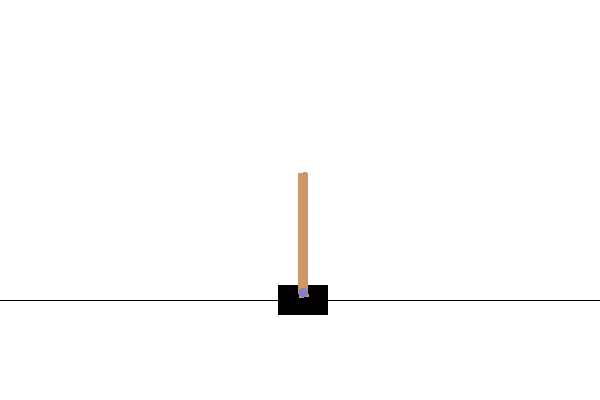
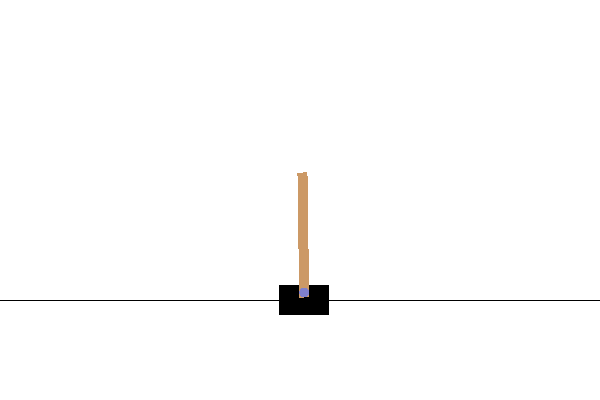
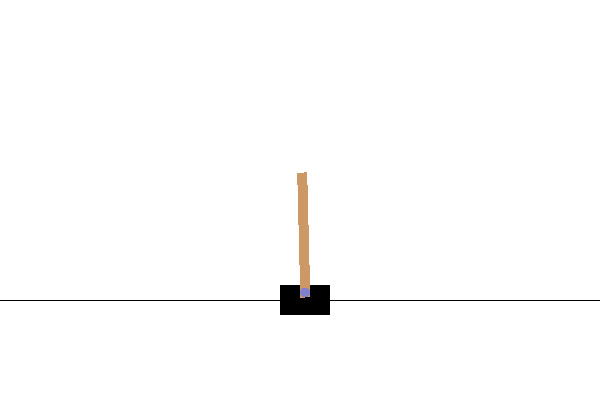
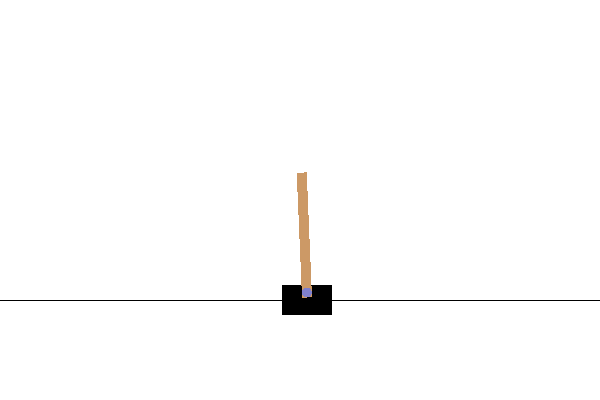
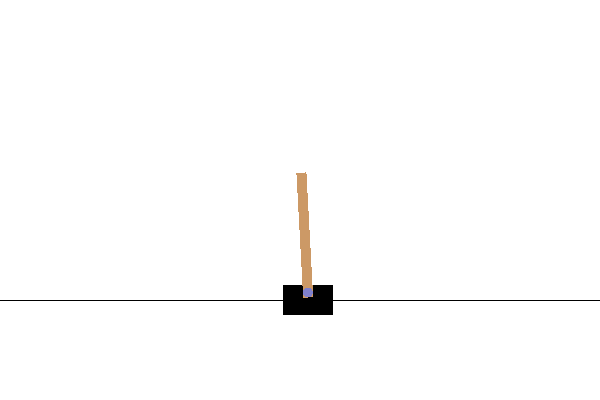
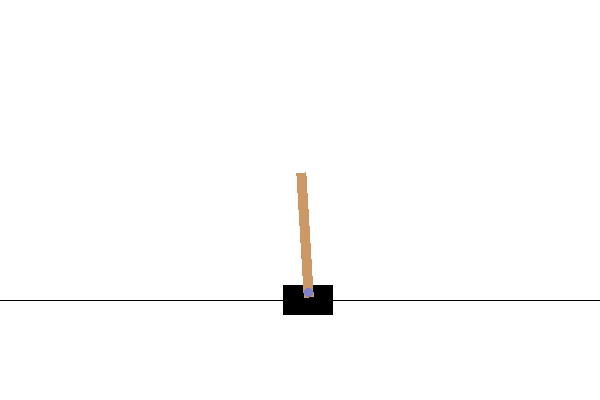
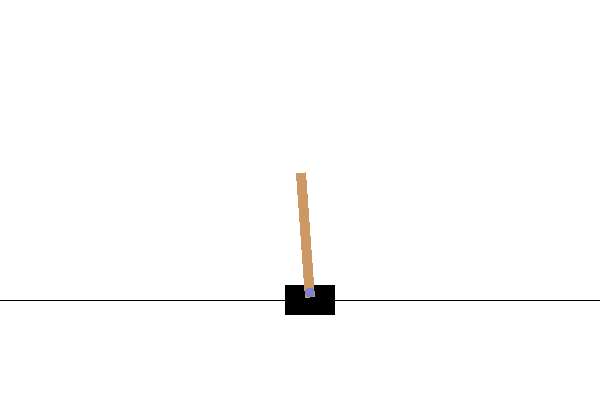
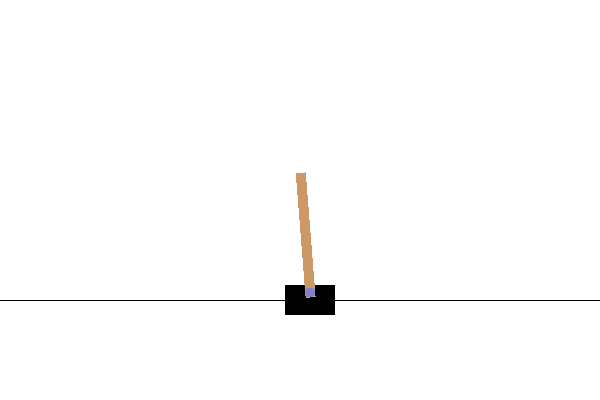
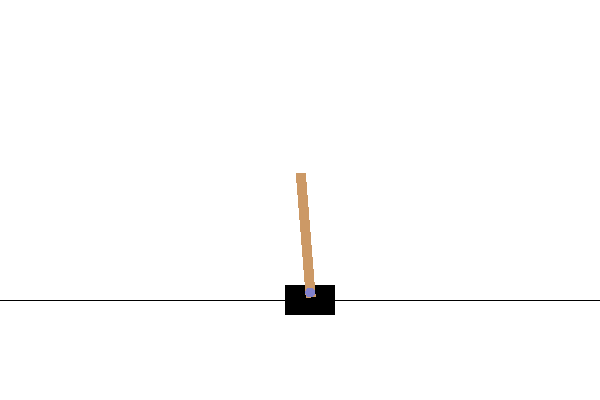
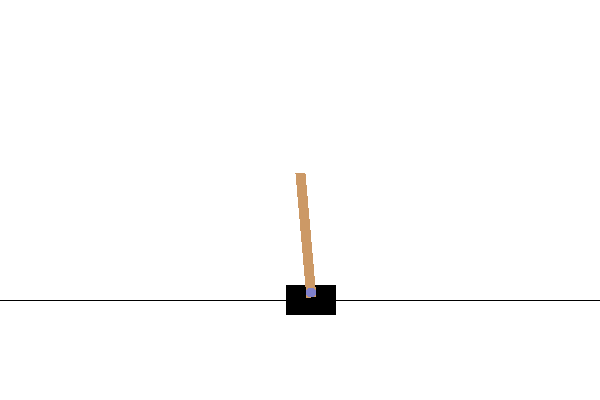
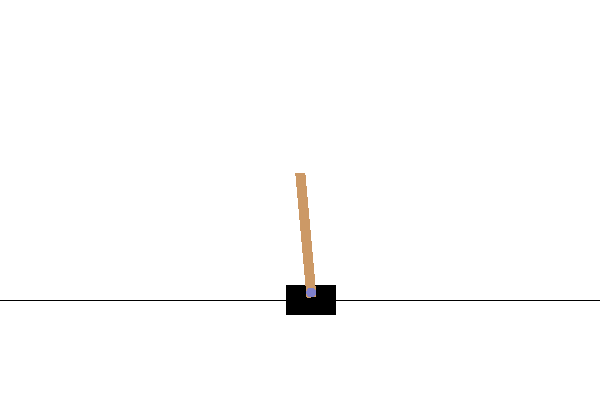
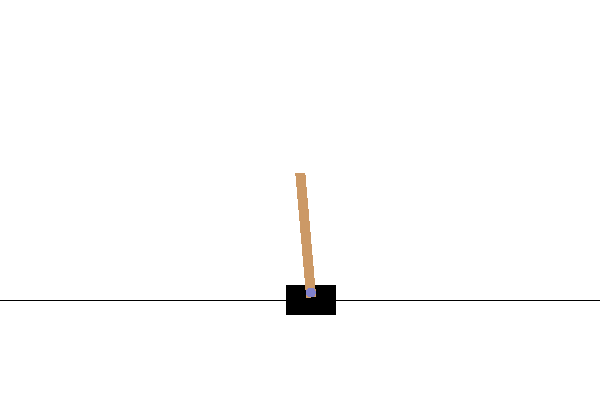
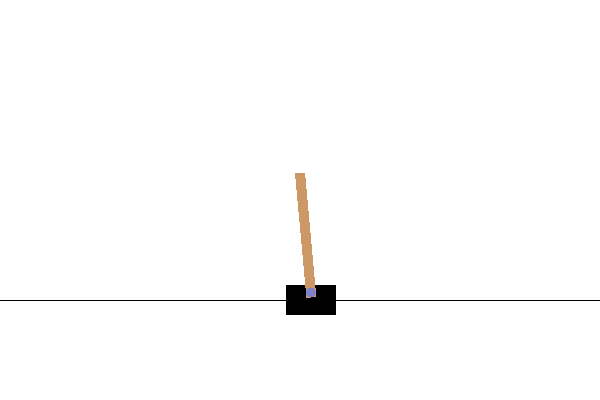
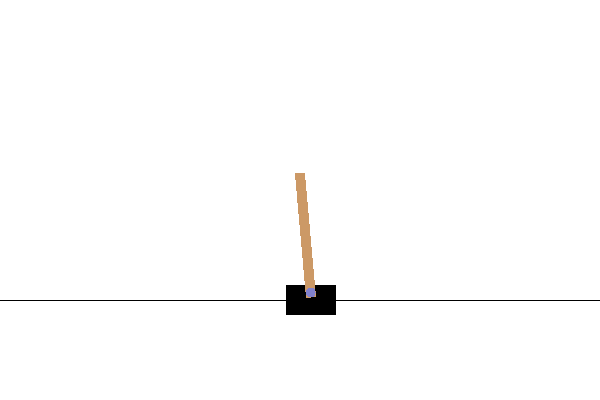
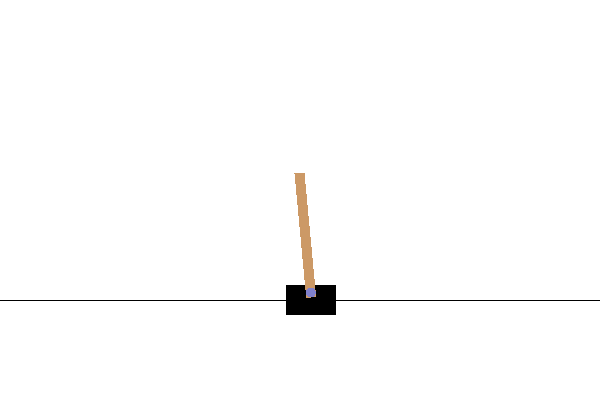
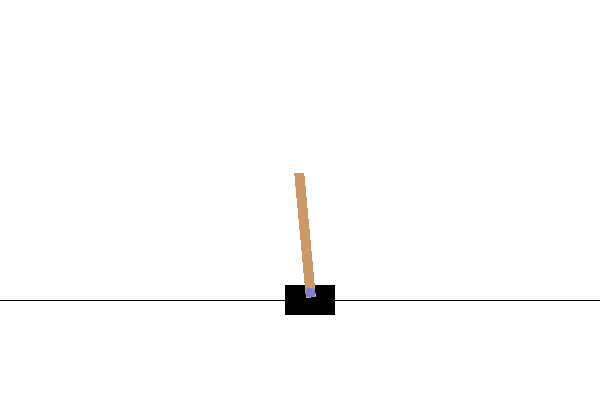
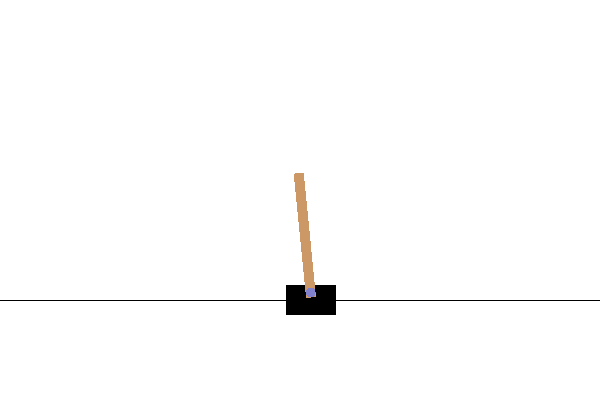
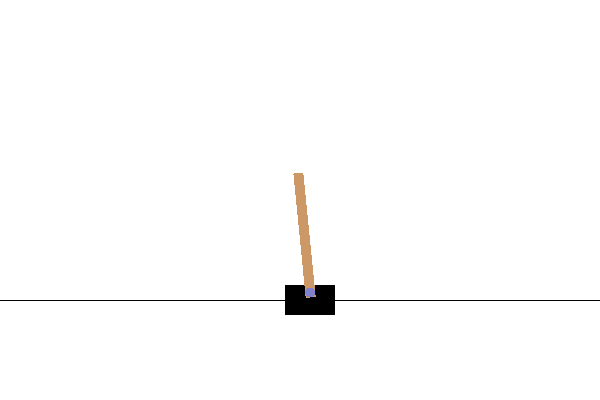
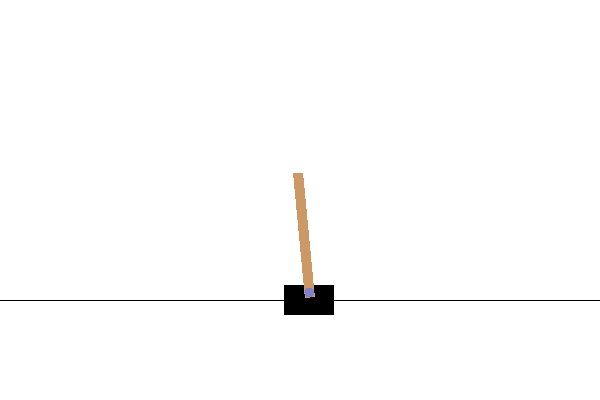
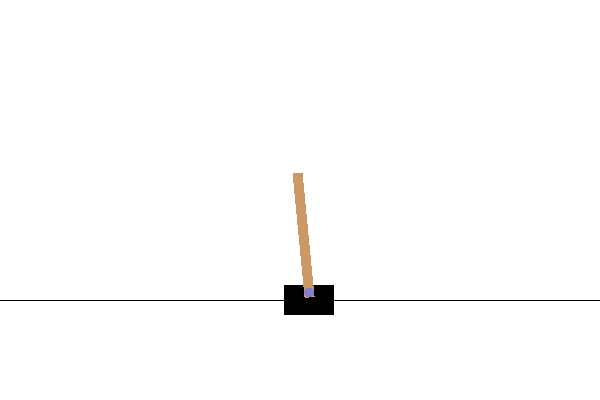
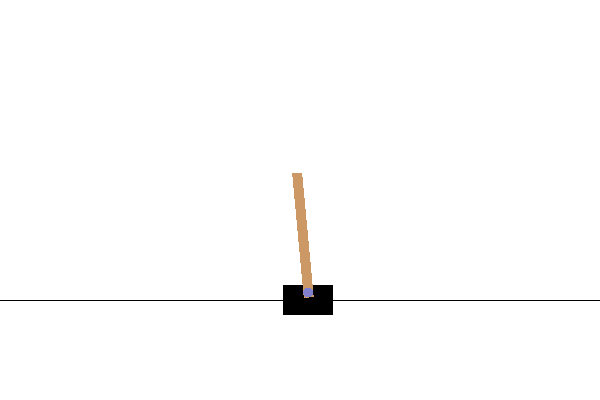
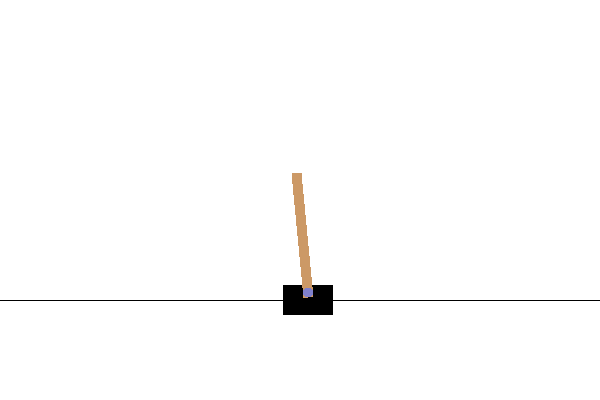
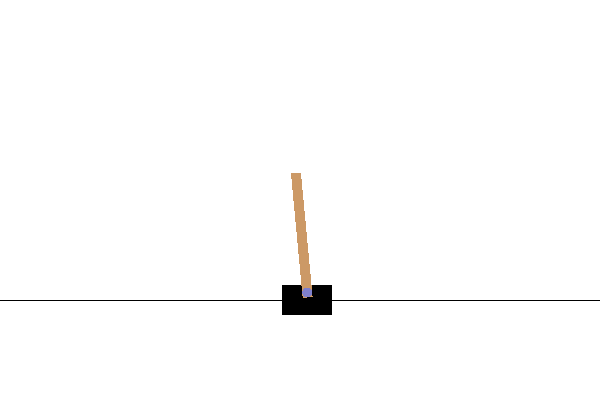
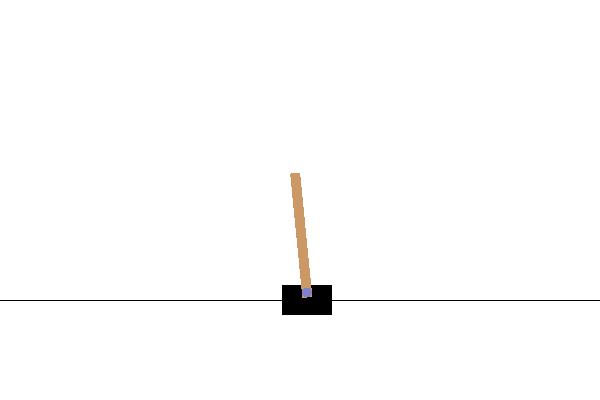
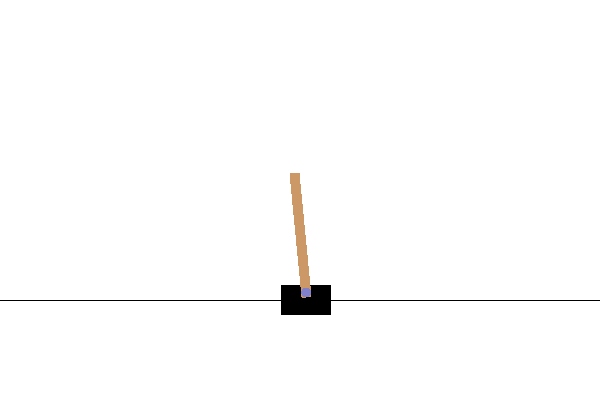
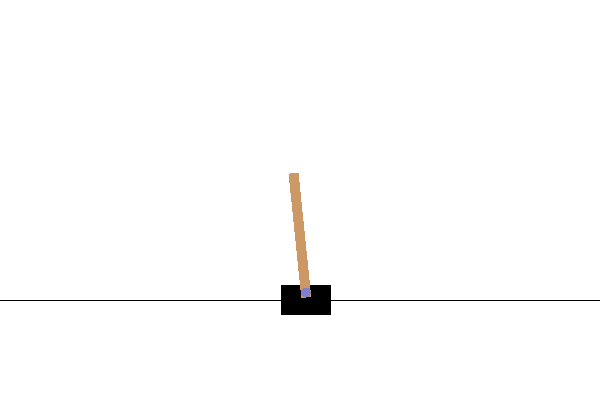
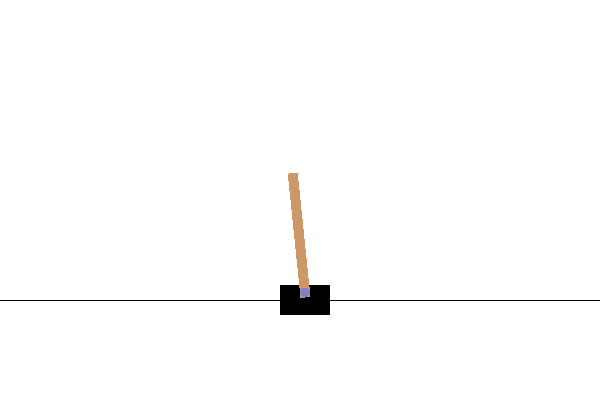
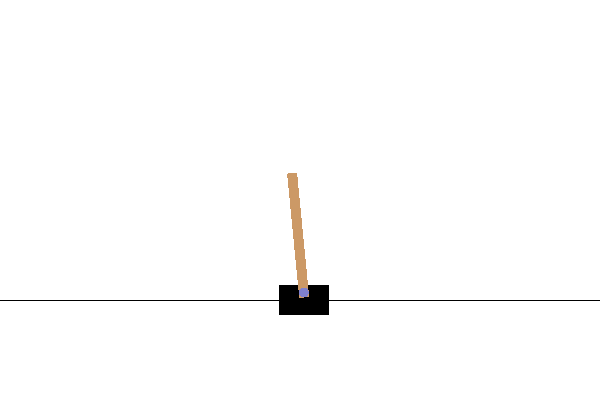
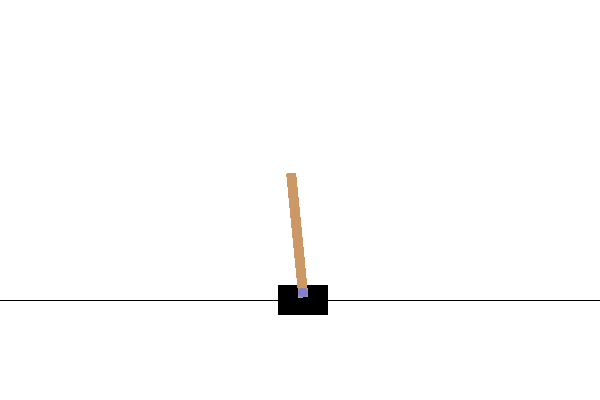
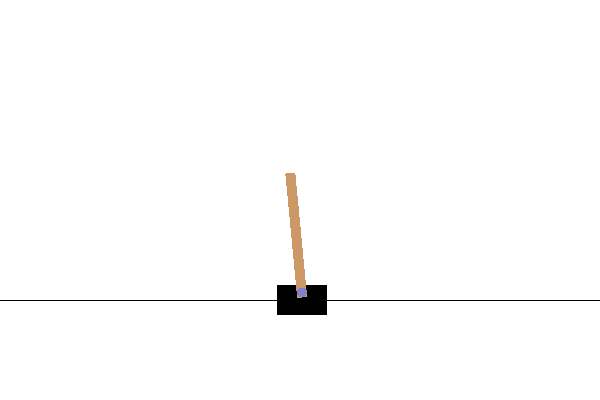
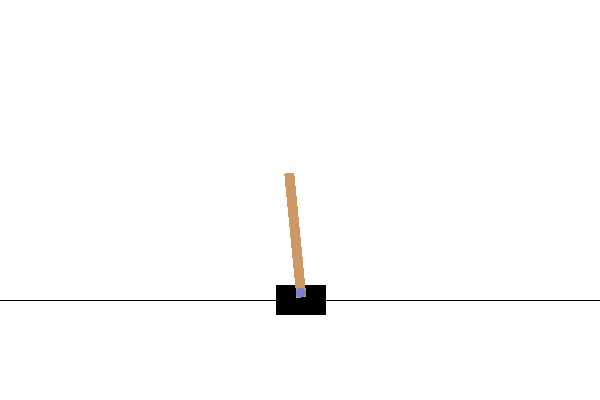
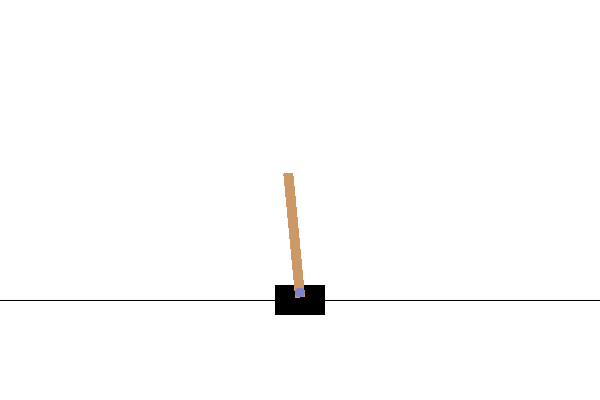
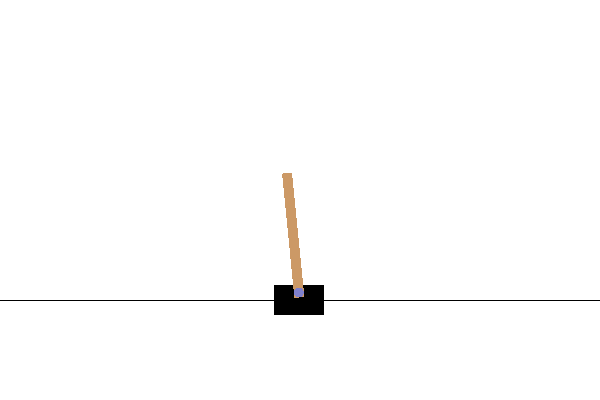
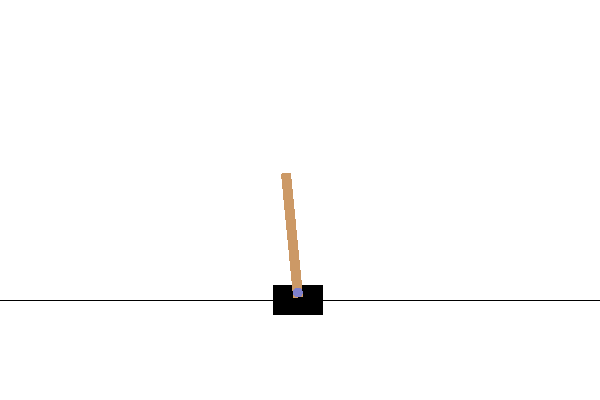
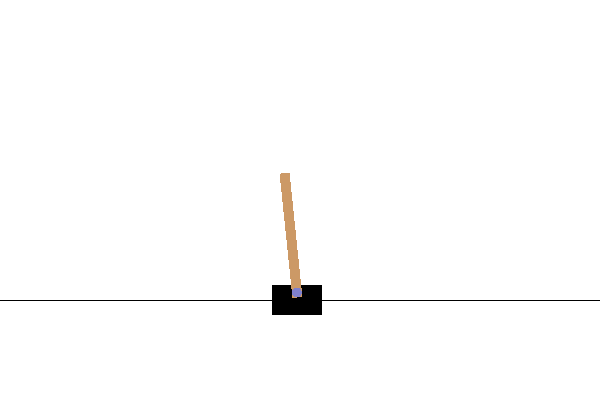
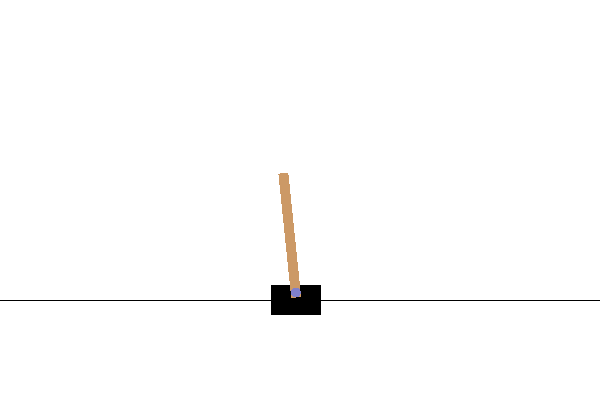
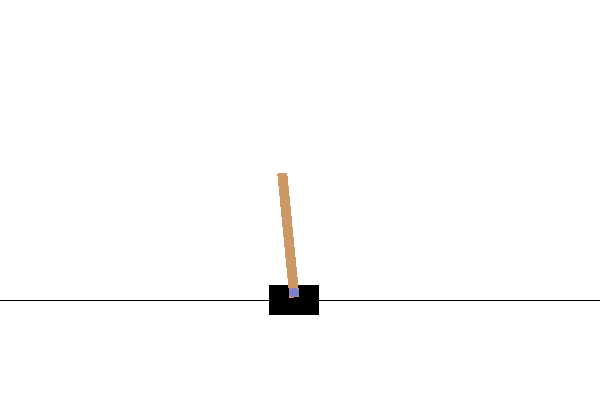
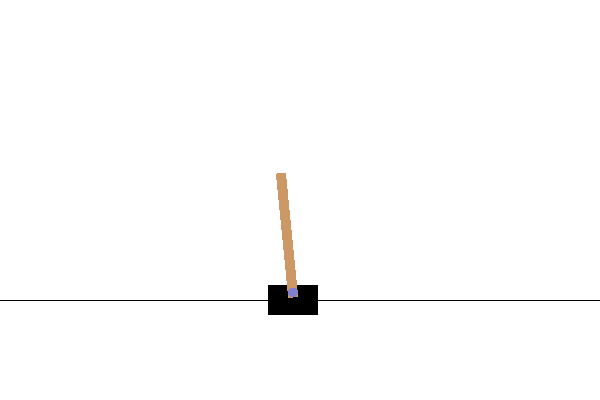
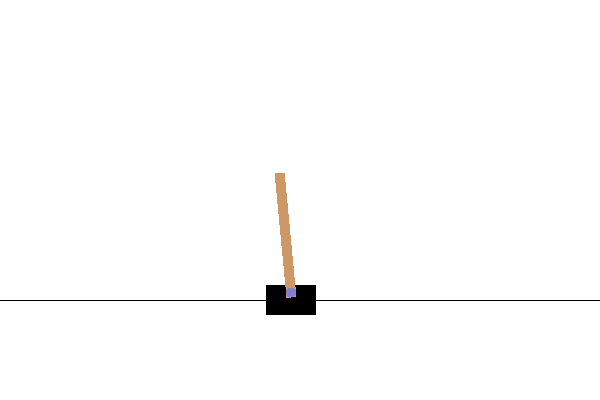
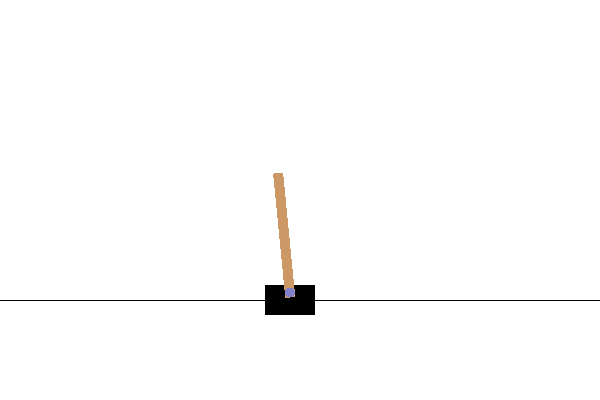
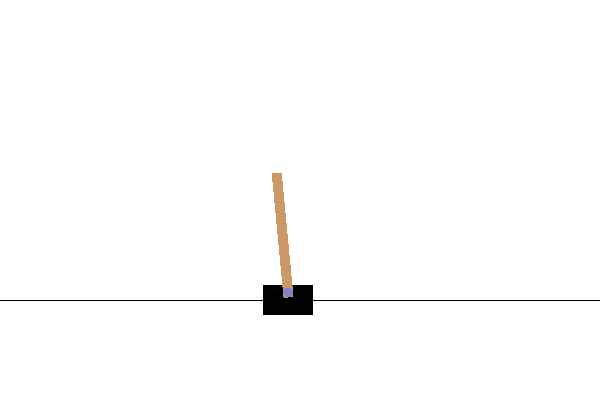
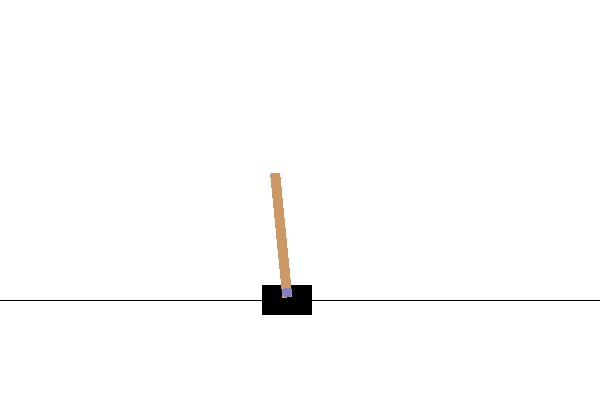
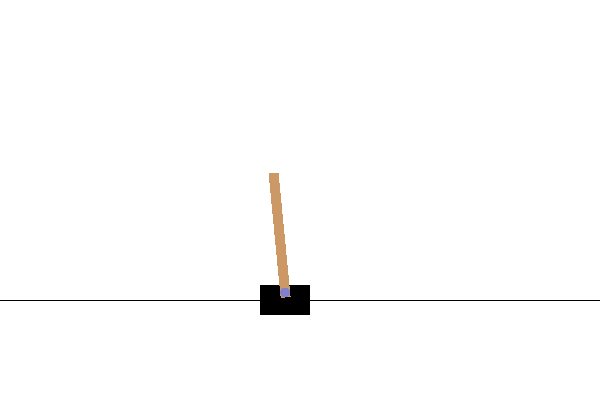
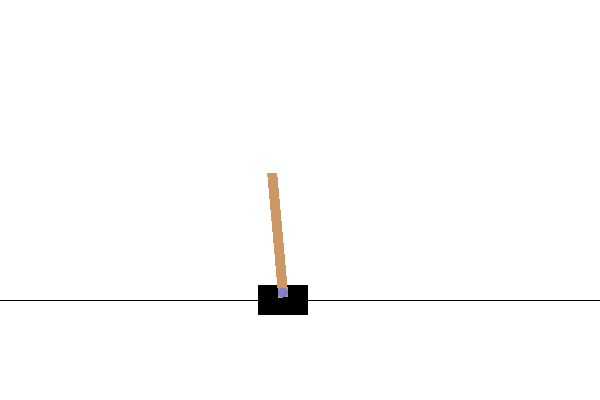
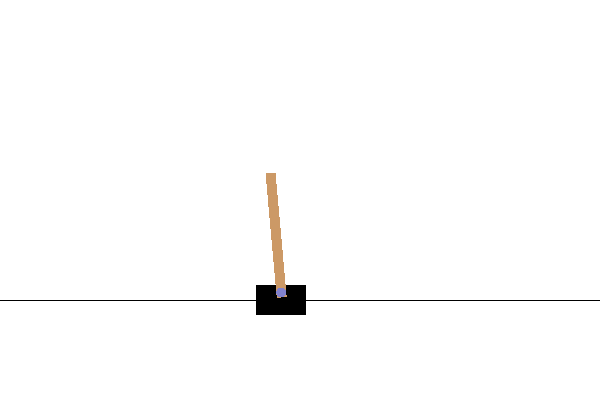
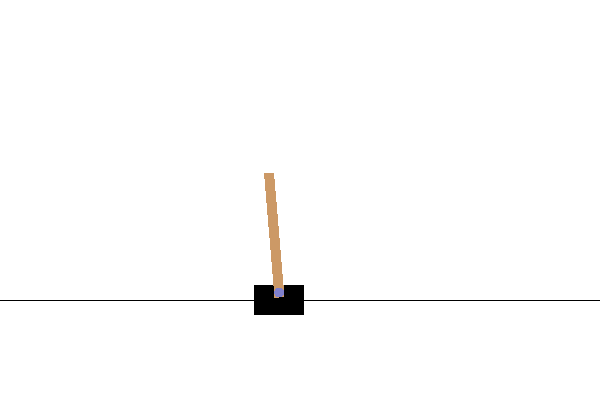
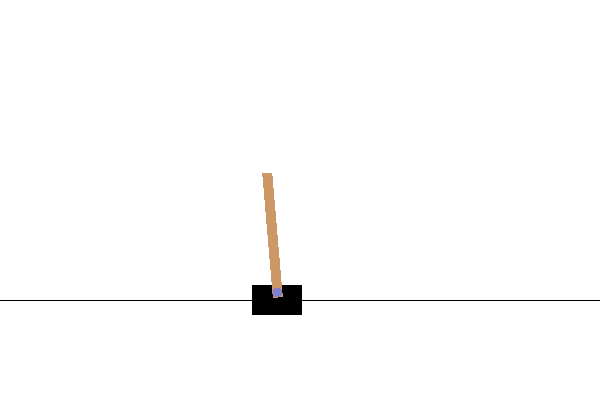
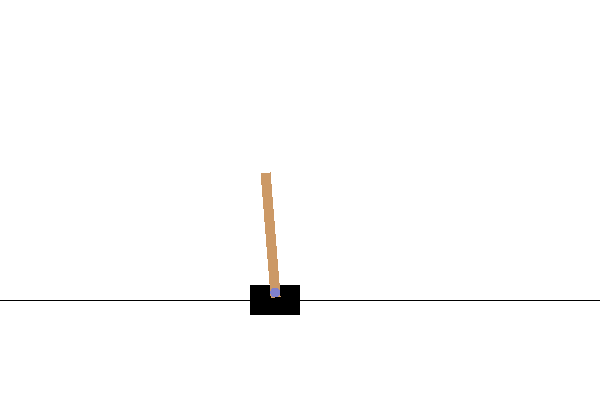
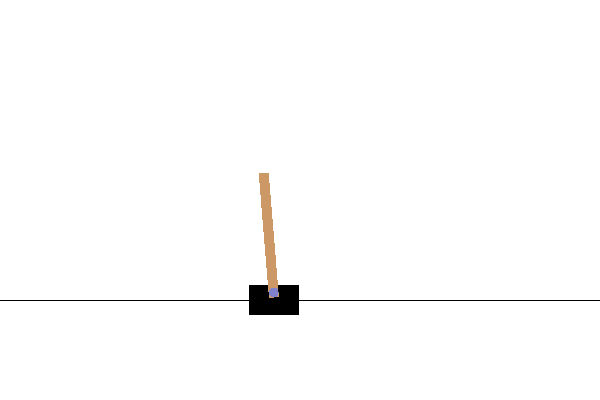
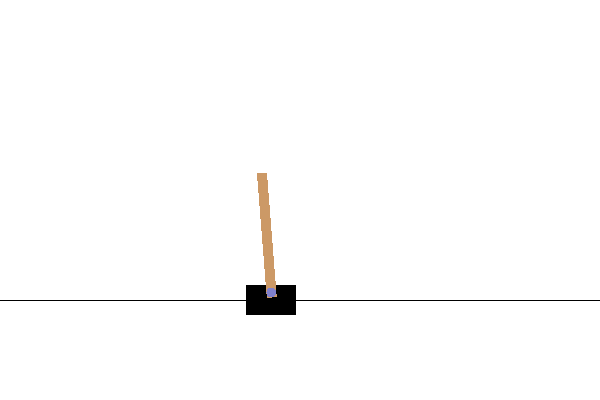
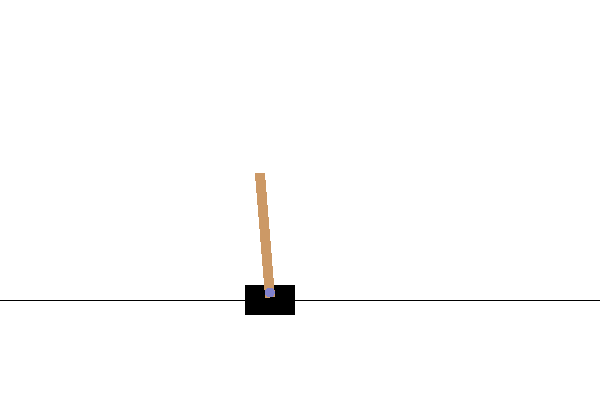
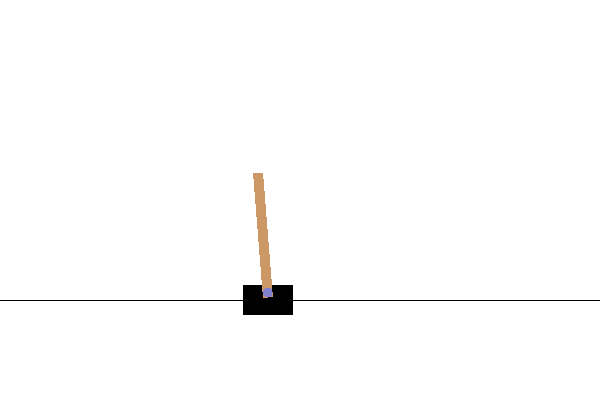
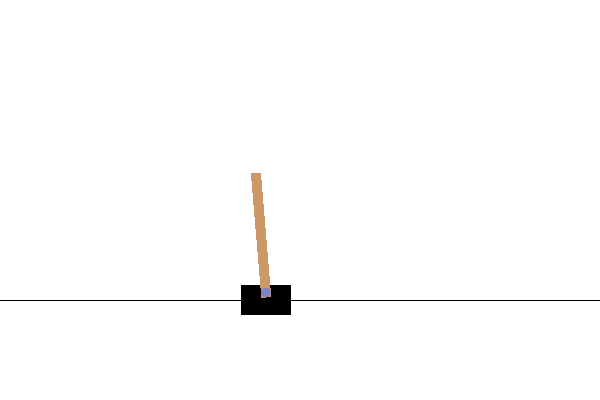
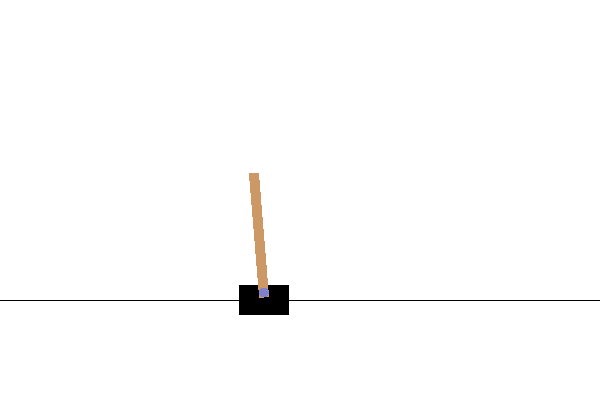
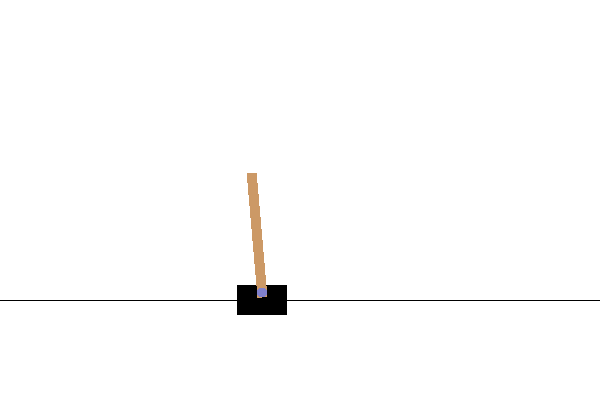
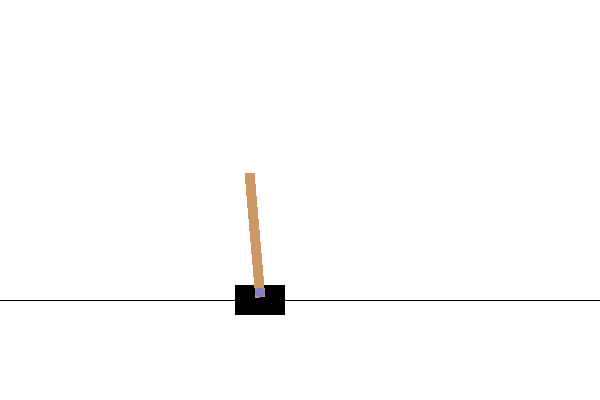
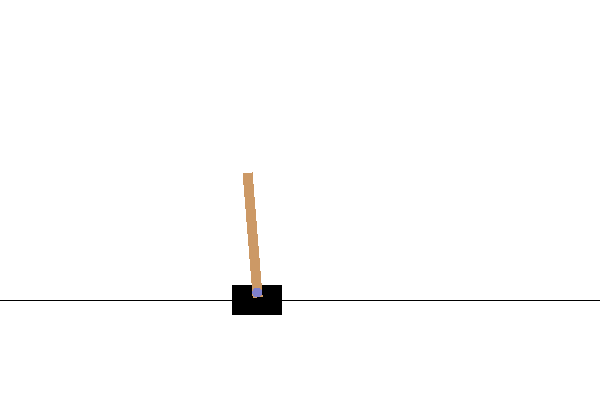
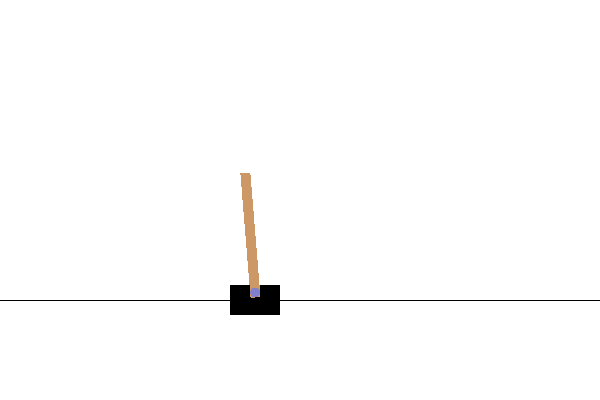
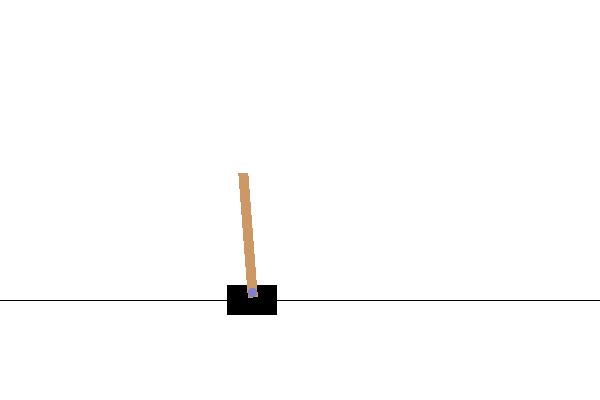
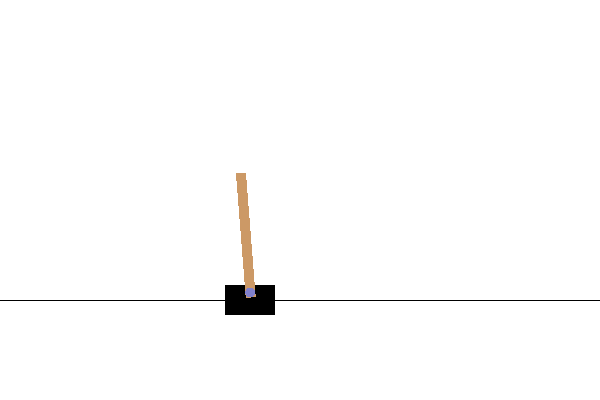
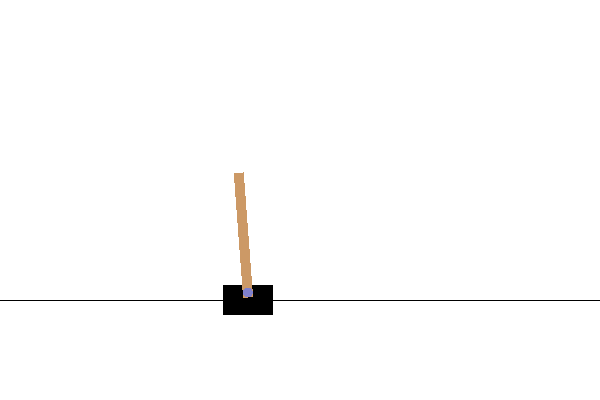
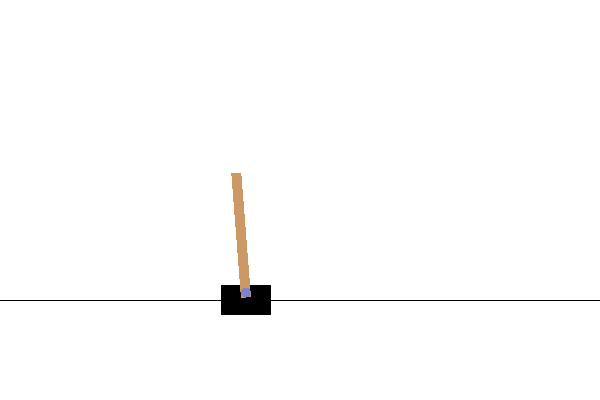
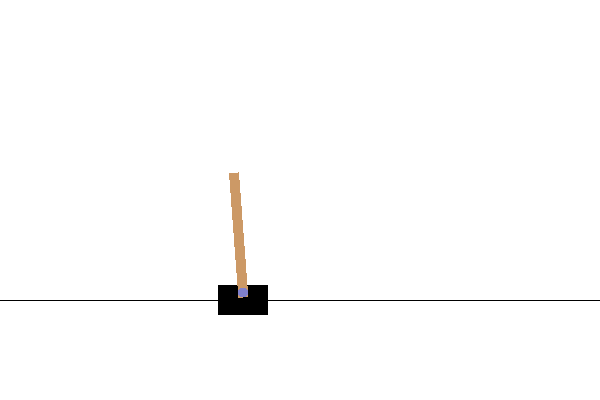
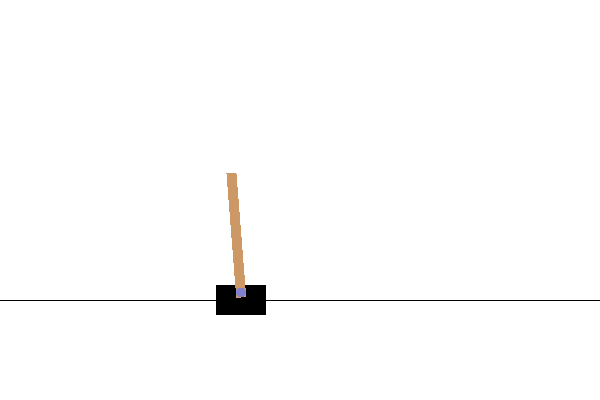
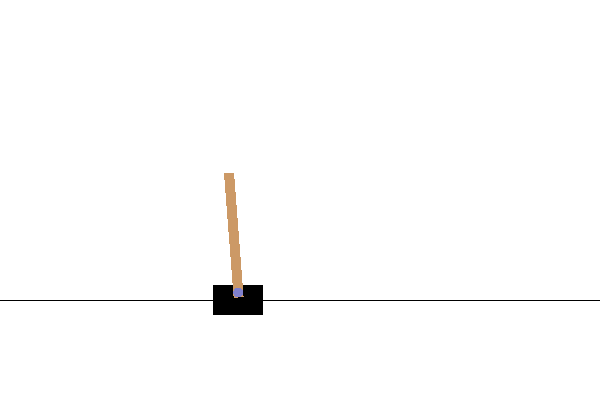
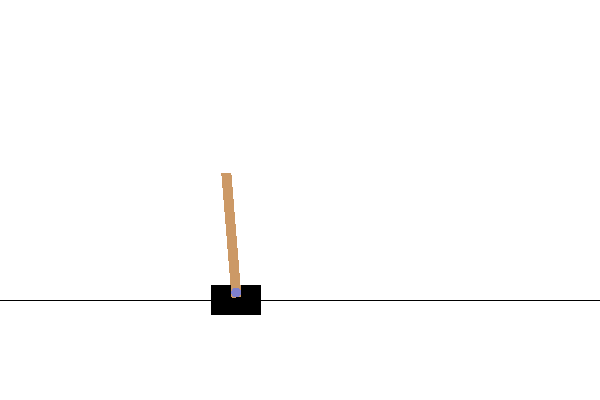
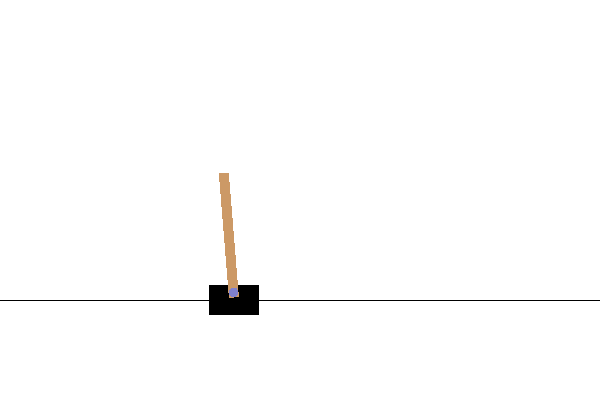
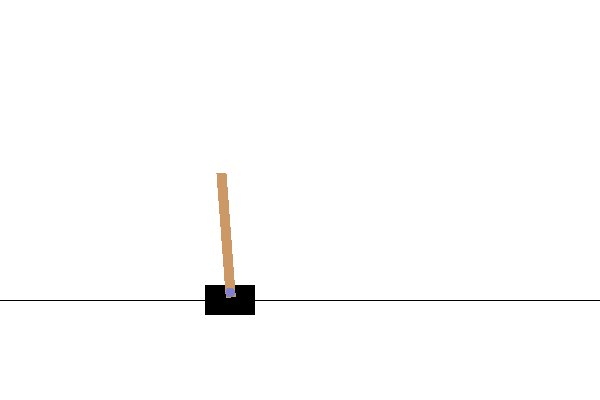
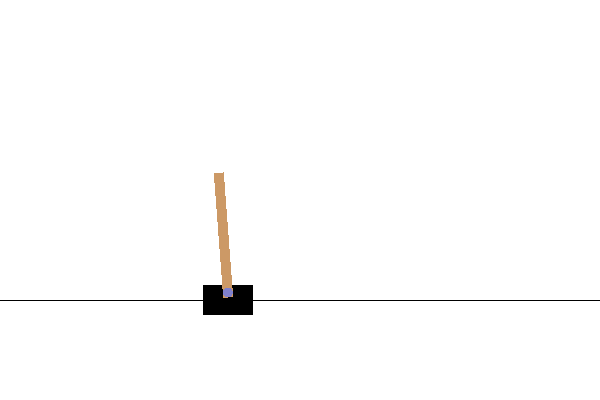
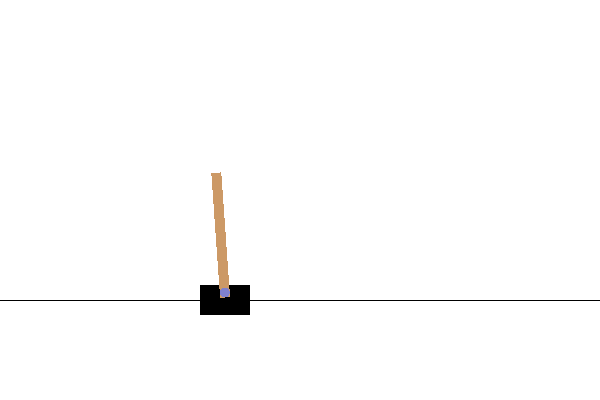
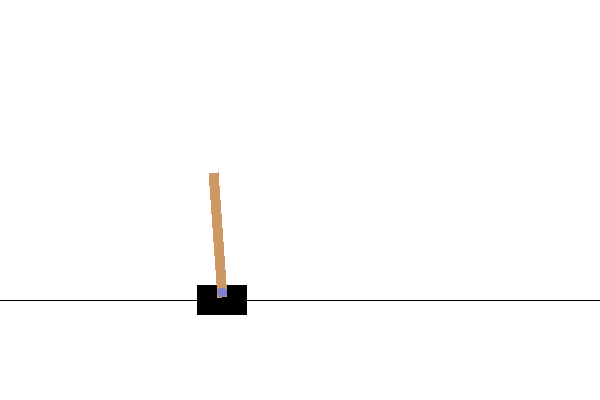
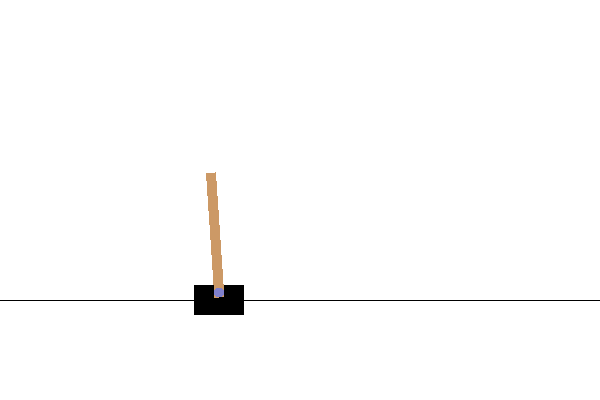
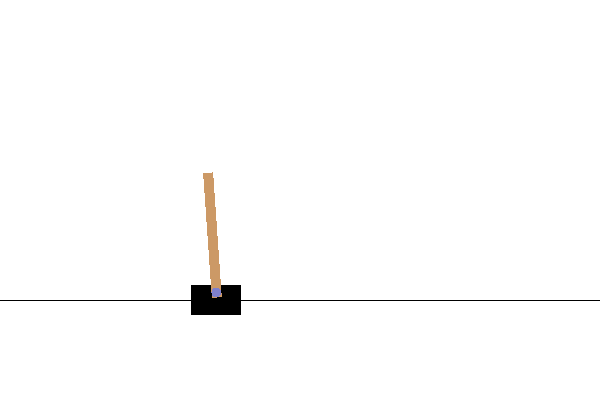
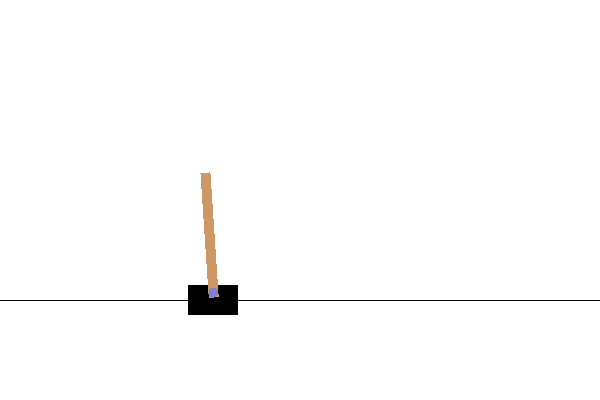
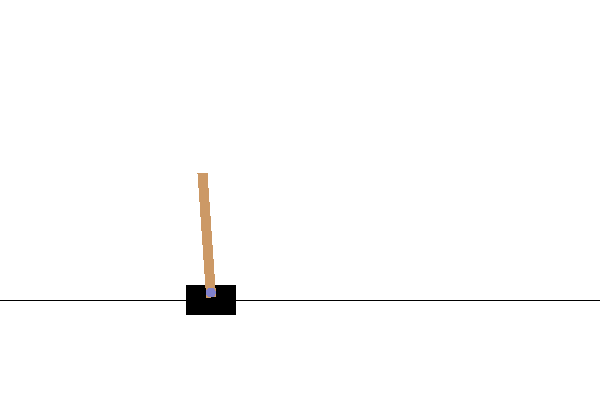
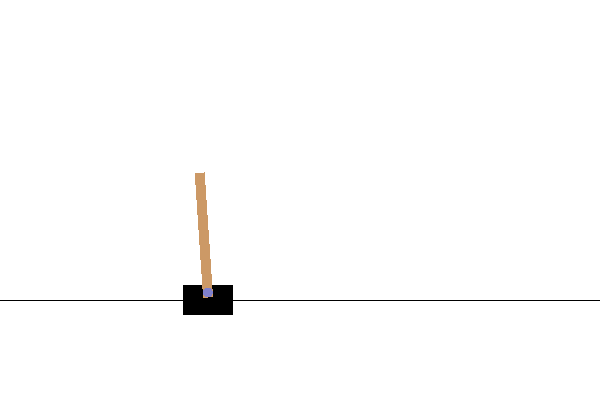
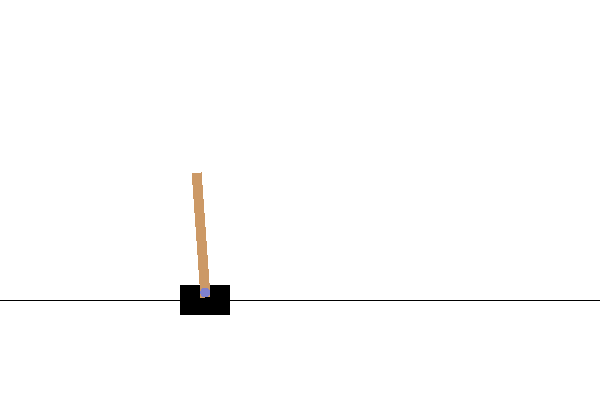
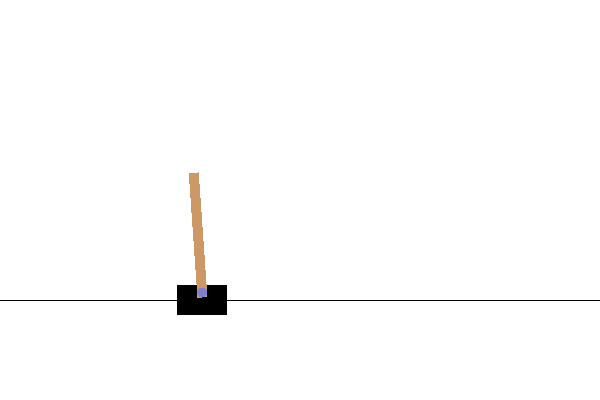
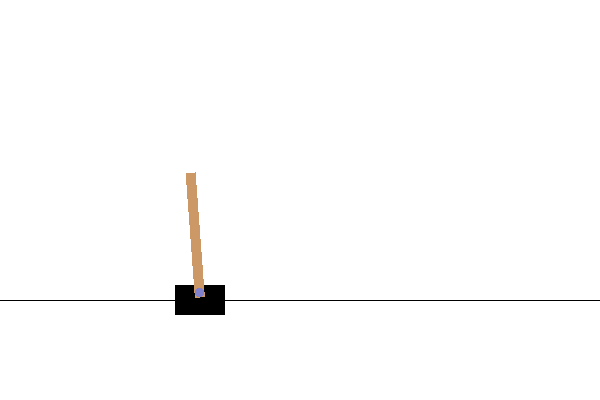
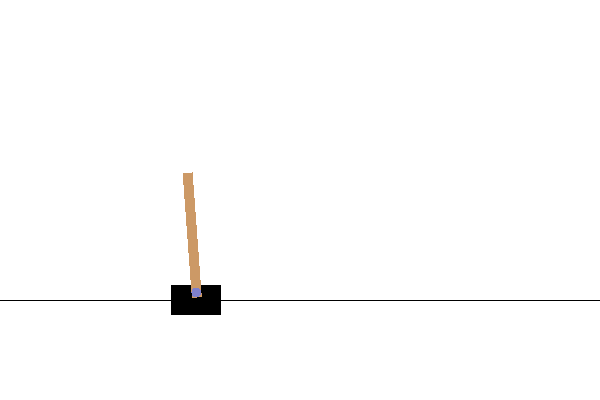
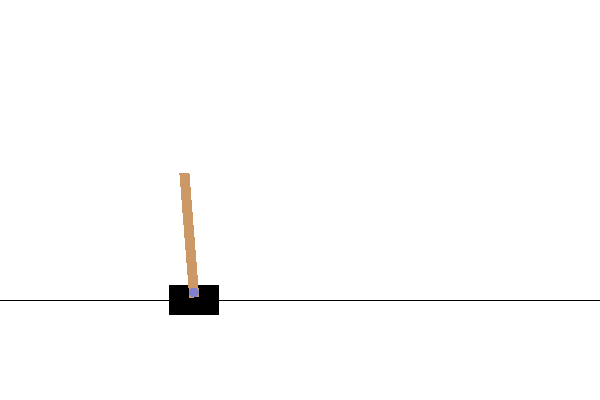
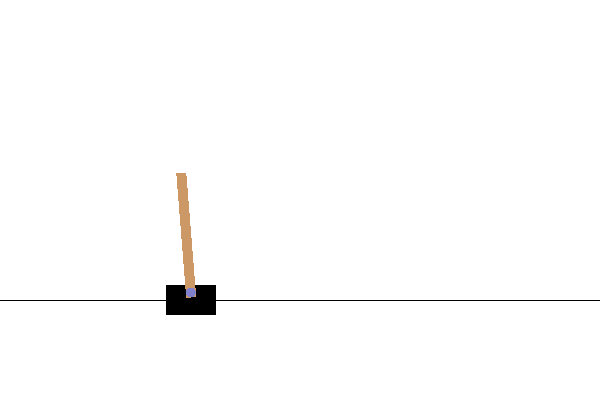
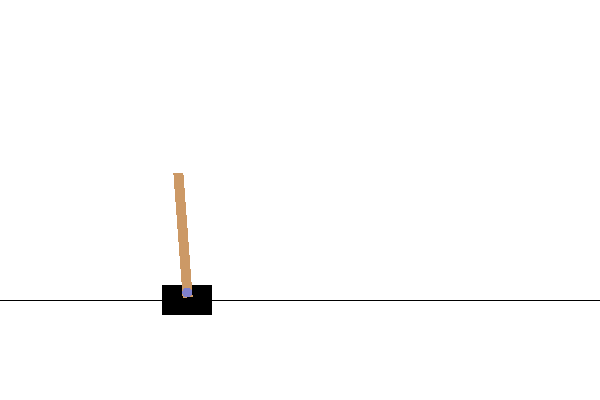
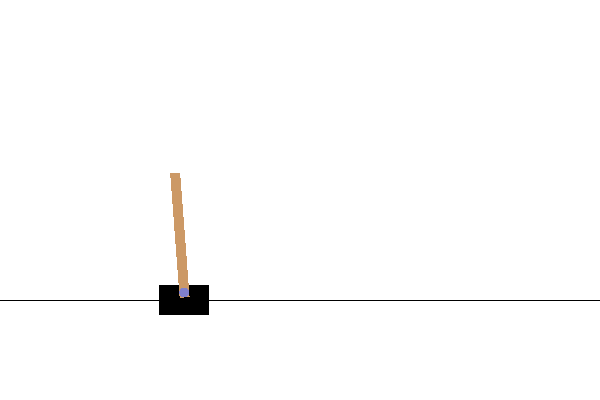
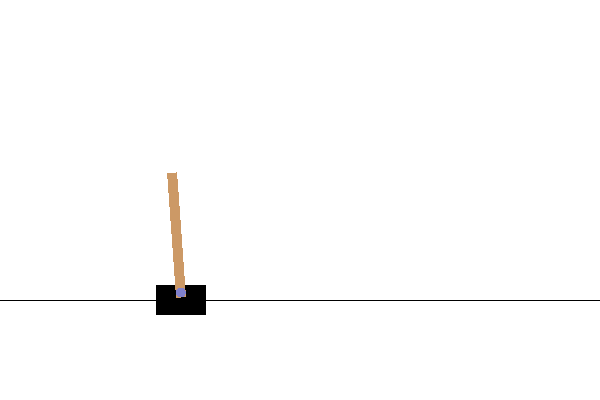
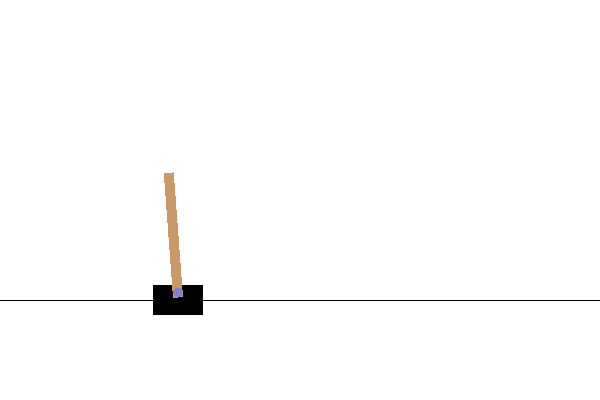
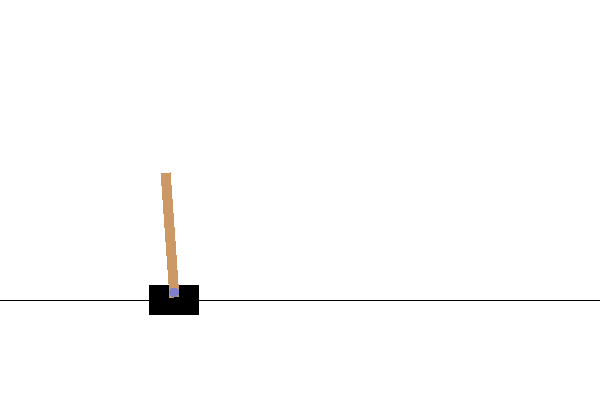
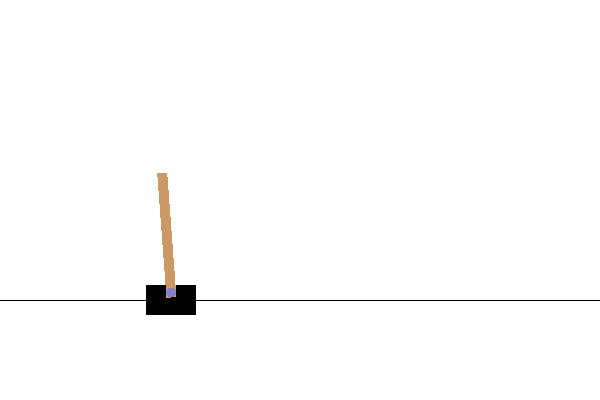
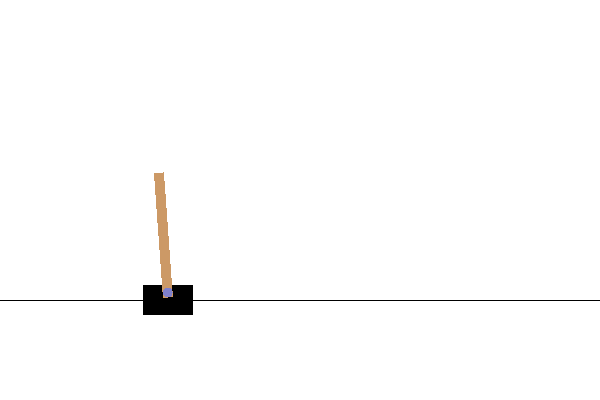
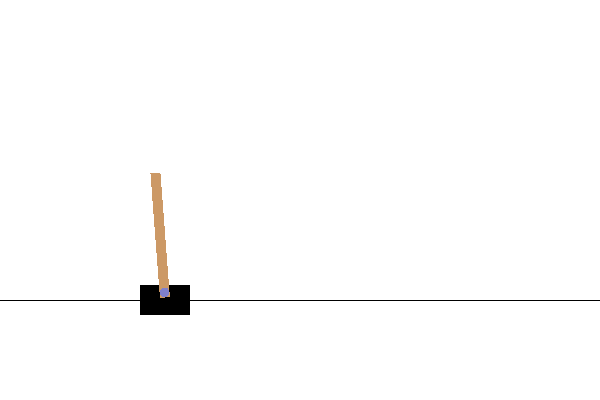
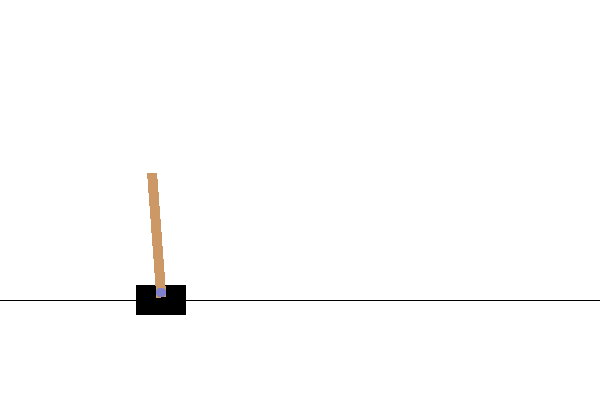
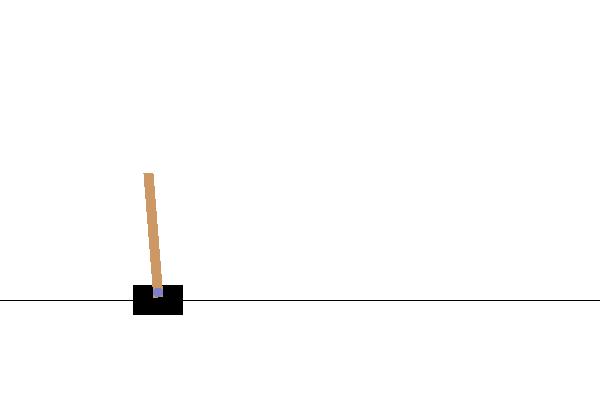
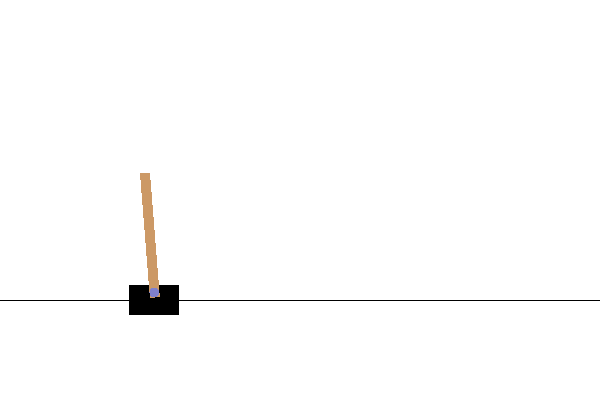
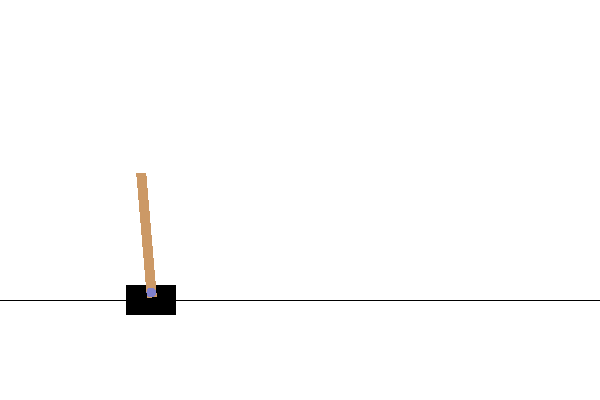
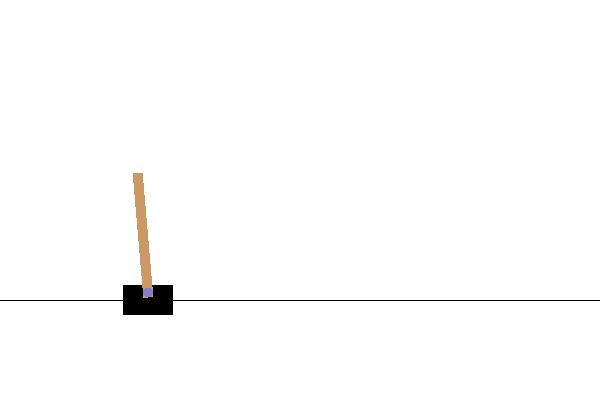
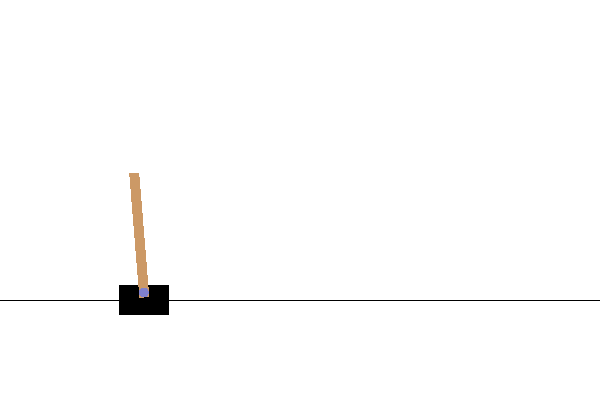
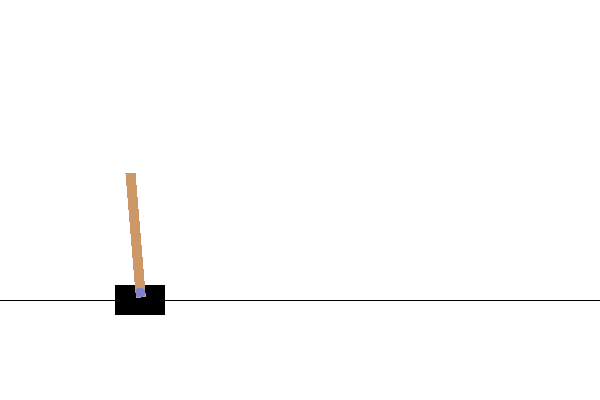
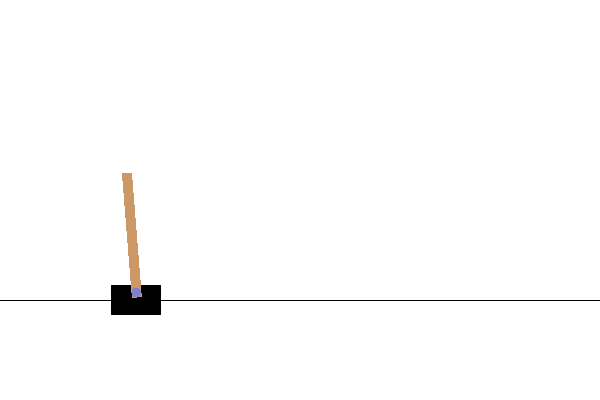
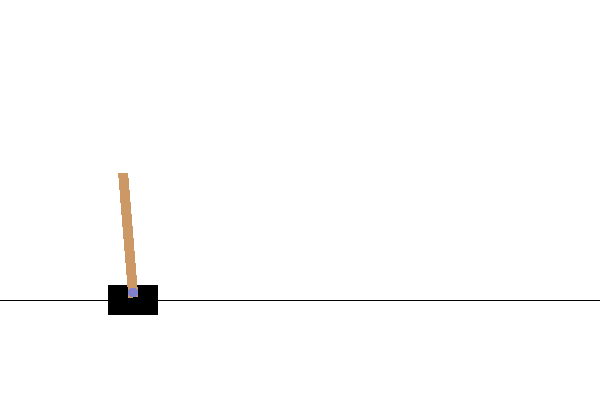
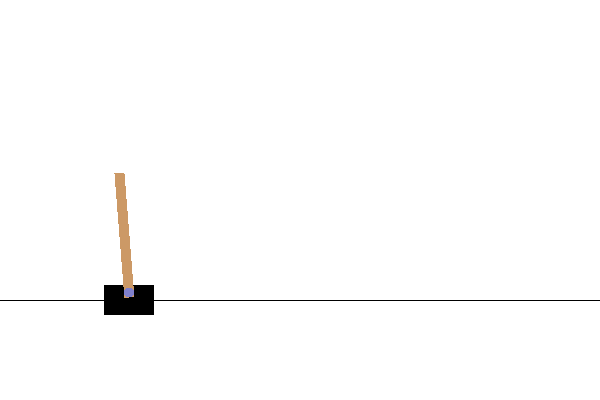
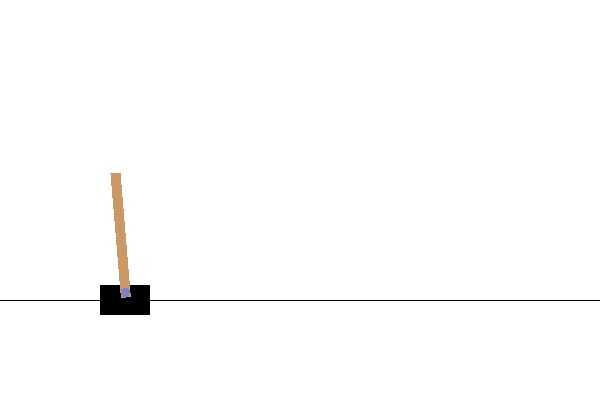
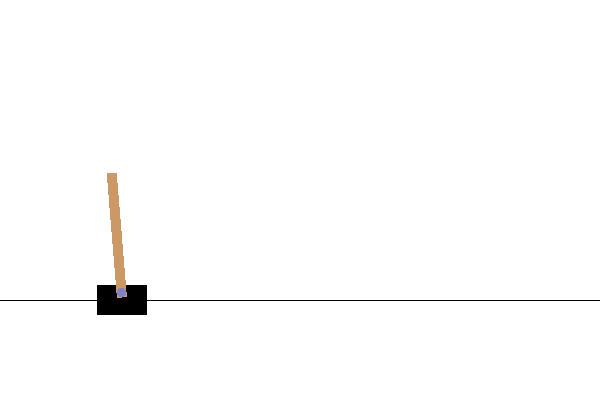
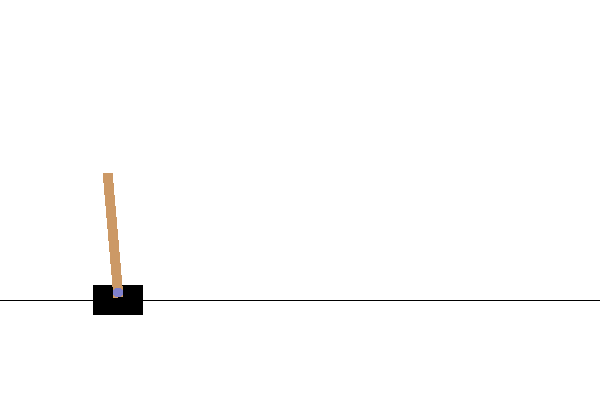
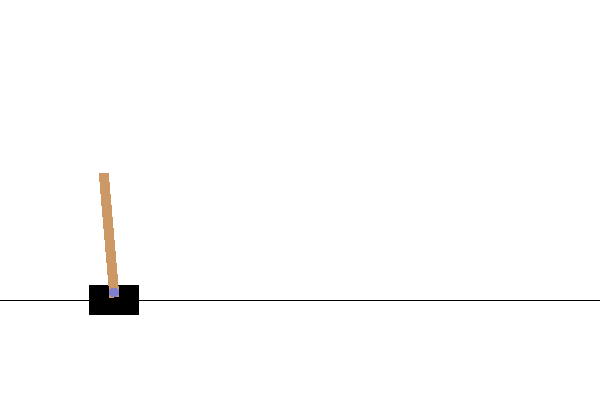
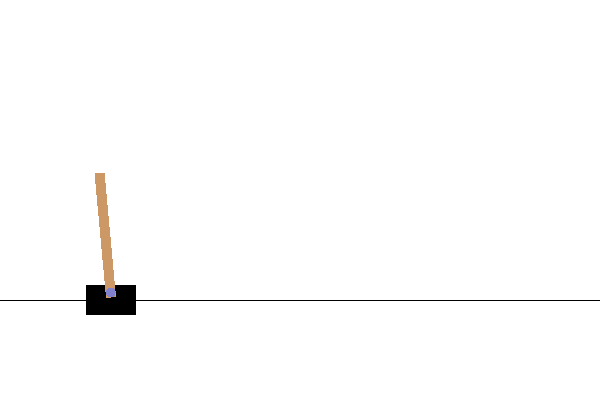
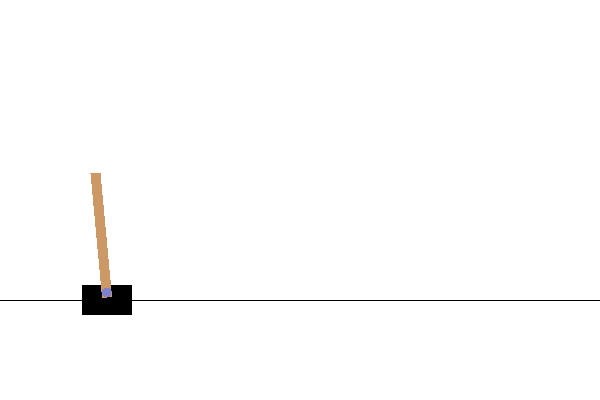
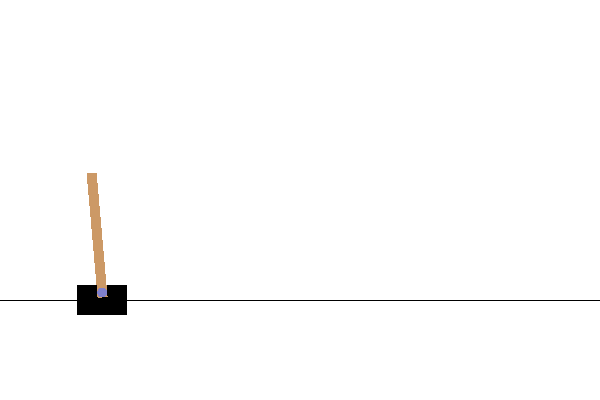
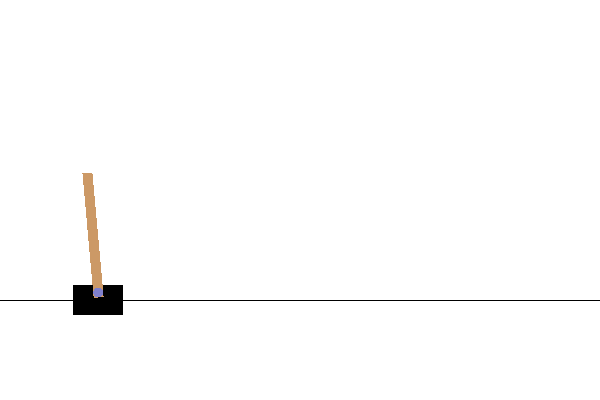
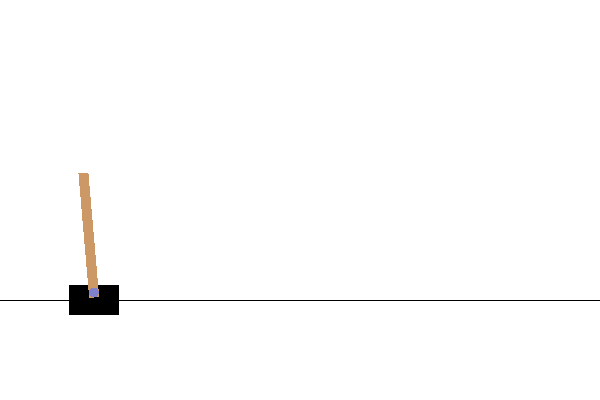
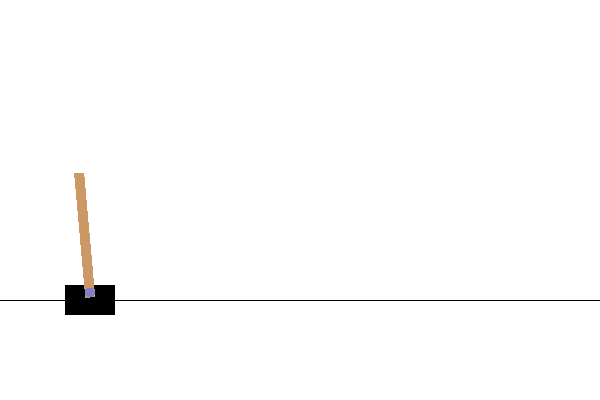
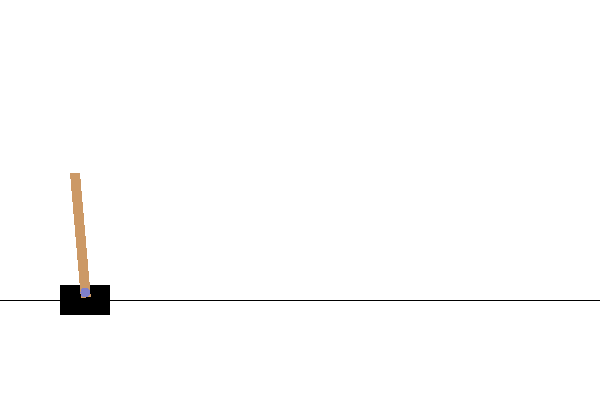
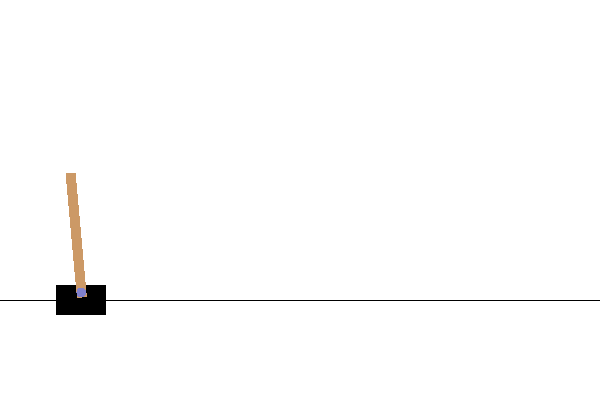
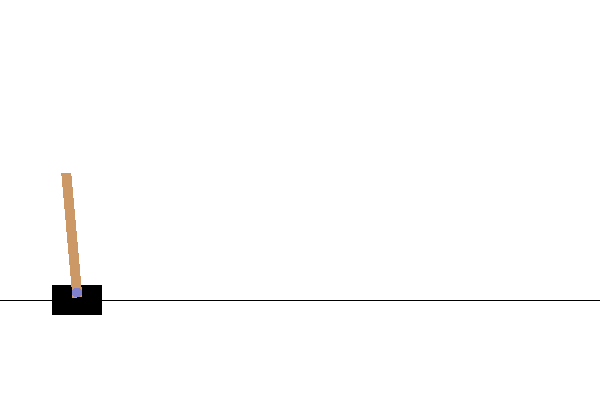
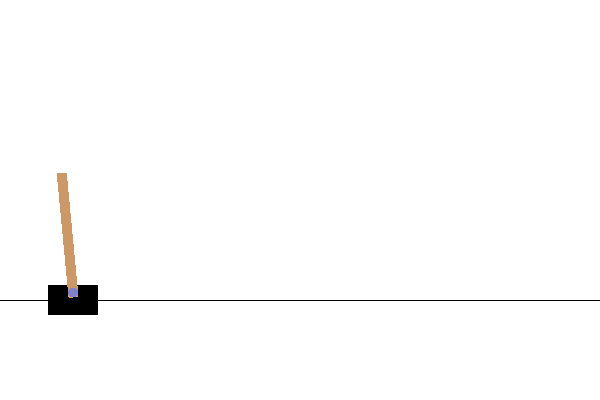
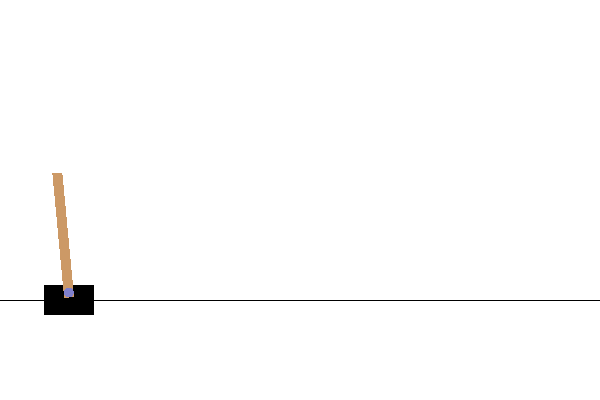
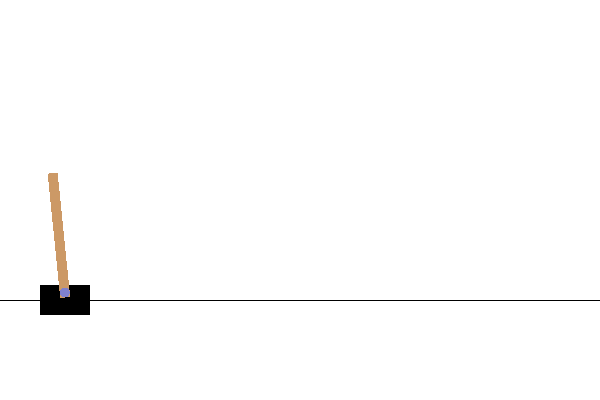
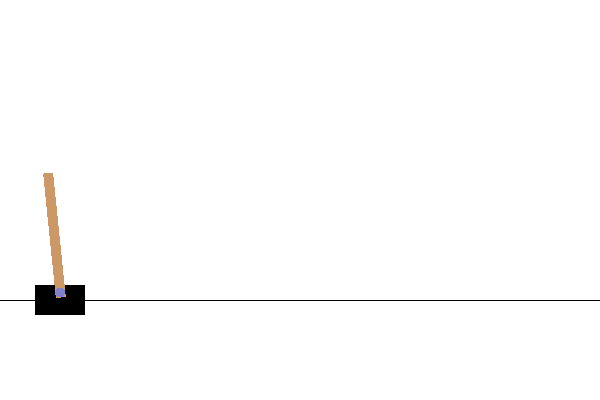
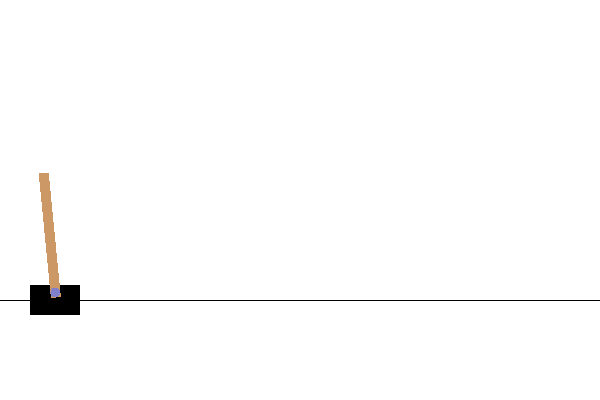
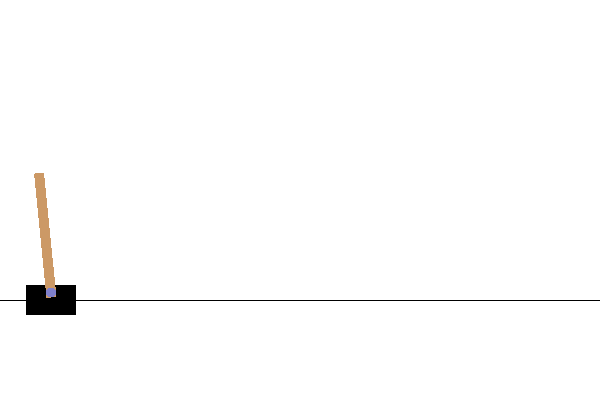
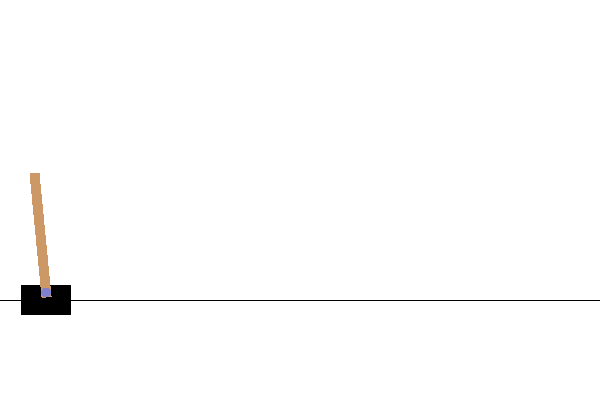
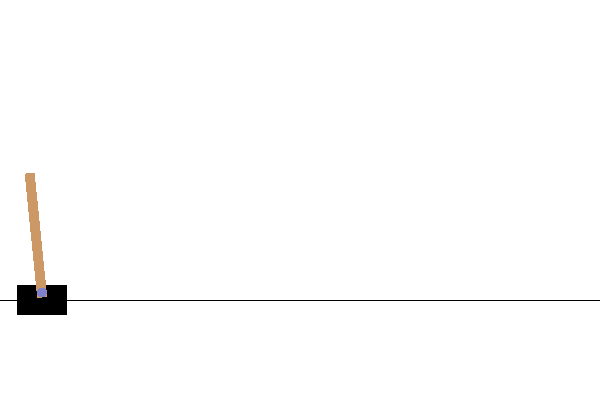
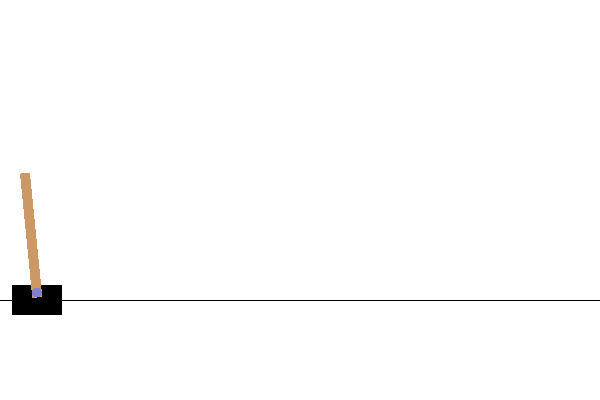
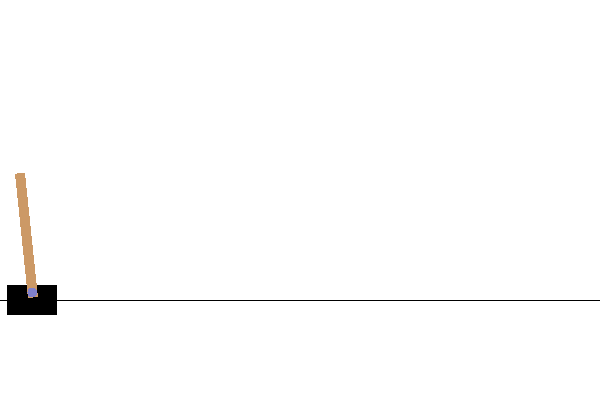
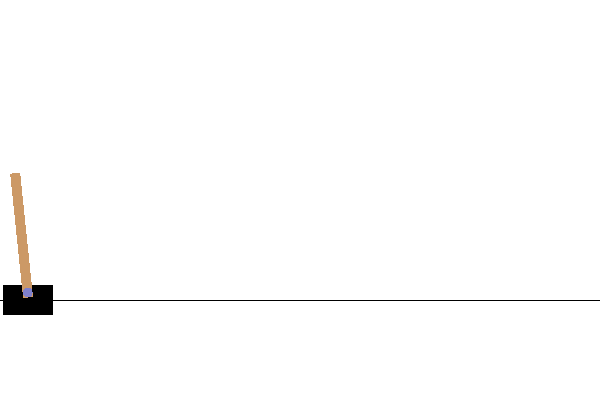
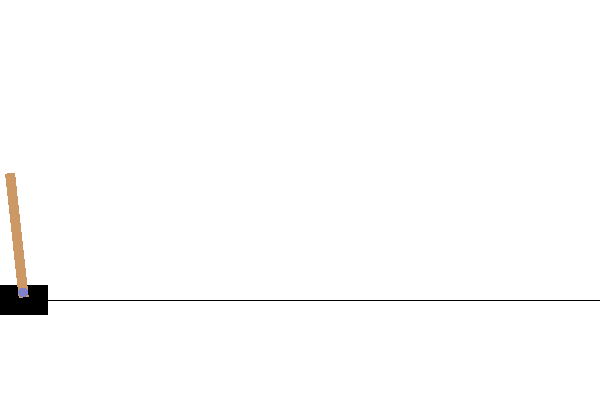
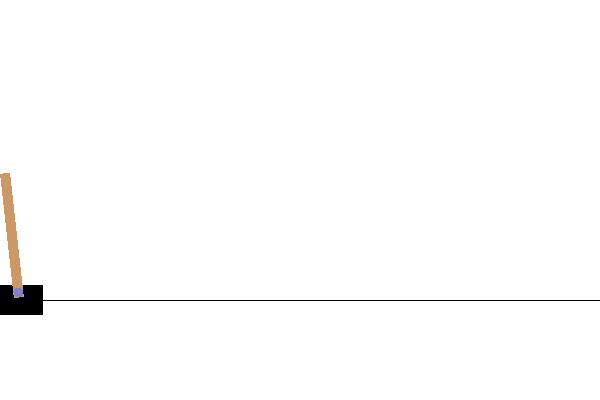
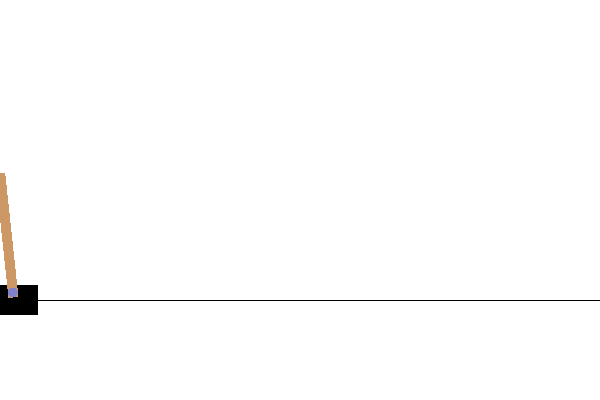
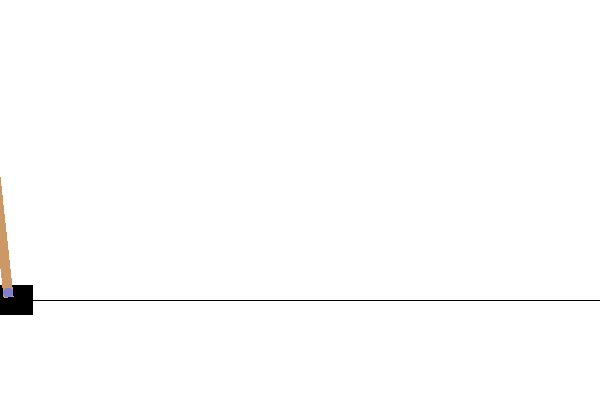
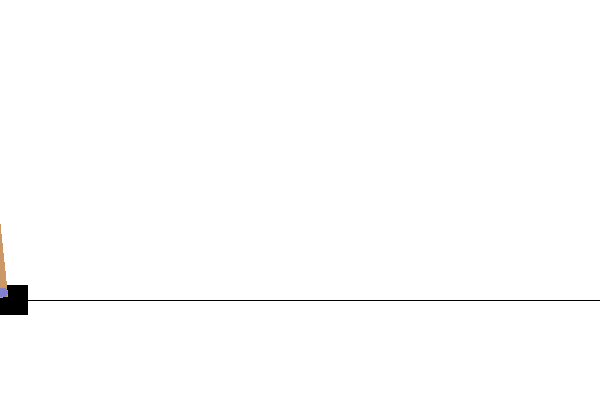
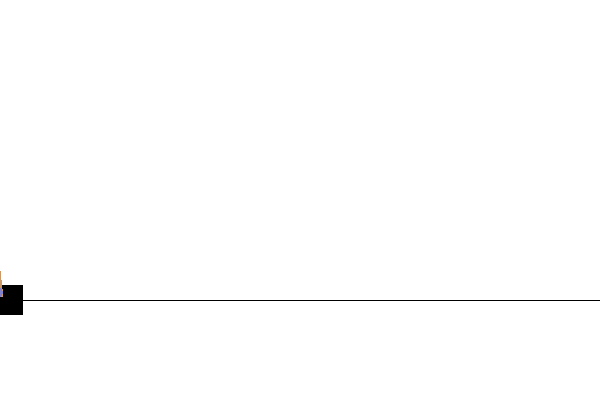

In [36]:
% matplotlib inline
plot_movie_js(images[6])

In [53]:
% matplotlib inline
plot_movie_mp4(images[6])